## ⚽ Football ETL – Transfermarkt ➜ Spark ➜ MongoDB + Neo4j
###  João Vitor Averaldo Antunes (813979) · Pedro Enrico Barchi Nogueira (813099) · Rafael Mori Pinheiro (813851)

UFSCar-CC-So-PMD2025-Grupo 10

### Profa. Dra. Sahudy Montenegro González


# Configuração do Ambiente de Execução

Este notebook requer uma configuração de ambiente específica para garantir que o Apache Spark, Delta Lake e os conectores de banco de dados funcionem corretamente. 

---

### 1. Requisitos de Sistema

As seguintes tecnologias devem estar instaladas e configuradas na máquina local:

* **Java Development Kit (JDK):** Versão **17 ou superior**.
    * *Motivo:* O Apache Spark executa na JVM (Java Virtual Machine).
    * *Verificação:* A variável de ambiente `JAVA_HOME` deve estar configurada e apontando para o diretório de instalação do JDK.

* **Apache Spark (Binários):** Versão **4.0.0**.
    * *Motivo:* Esta é a engine de processamento massivo de dados utilizada.
    * *Verificação:* A variável de ambiente `SPARK_HOME` deve estar configurada e apontando para o diretório onde o Spark foi descompactado.

* **Python:** Versão **3.11.x**.
    * *Motivo:* As bibliotecas `pyspark` e `delta-spark` utilizadas neste projeto são compatíveis com esta versão do Python. Versões mais recentes (como 3.13+) podem causar erros de incompatibilidade.
    * *Recomendação (macOS/Linux):* Usar o `pyenv` para gerenciar a versão do Python (`pyenv install 3.11` e `pyenv local 3.11` na pasta do projeto).

---

### 2. Ambiente Virtual e Dependências Python

Para isolar as dependências, este projeto deve ser executado dentro de um ambiente virtual (`venv`).

1.  **Criação:** `python -m venv venv`
2.  **Ativação:** `source venv/bin/activate` (macOS/Linux) ou `.\venv\Scripts\activate` (Windows)

As bibliotecas Python necessárias serão instaladas pela célula de código abaixo. As principais são:
* `pyspark`: A API Python para interagir com o Spark.
* `delta-spark`: A biblioteca para habilitar o suporte ao formato Delta Lake.
* `python-dotenv`: Para gerenciar variáveis de ambiente (credenciais) a partir de um arquivo `.env`.

---

### 3. Arquivos de Conectores (.jar)

Devido a possíveis restrições de rede ou para garantir consistência, este projeto utiliza o método de carregamento manual de JARs. Crie uma pasta chamada `jars` na raiz do projeto e certifique-se de que ela contém os seguintes quatro arquivos:

1.  `delta-spark_2.13-4.0.0.jar`
2.  `delta-storage-4.0.0.jar`
3.  `mongo-spark-connector_2.13-10.5.0.jar`
4.  `mongodb-driver-sync-5.5.1.jar`
5.  `mongodb-driver-core-5.1.2.jar`
6.  `neo4j-connector-apache-spark_2.13-5.3.8_for_spark_3.jar`
7.  `bson-5.1.2.jar`

---

### 4. Arquivo de Variáveis de Ambiente (`.env`)

Crie um arquivo chamado `.env` na raiz do projeto para armazenar as credenciais dos bancos de dados de forma segura. O arquivo deve seguir o seguinte formato:

```plaintext
# Credenciais do MongoDB
MONGO_URI="mongodb+srv://<user>:<password>@<cluster-url>/"

# Credenciais do Neo4j
NEO4J_URI="bolt://localhost:7687"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="your_password"

In [1]:
import os
import sys

# Instala os pacotes necessários
!{sys.executable} -m pip install "pyspark>=4.0.0" "delta-spark>=4.0.0" pandas python-dotenv matplotlib seaborn jinja2 ipython pymongo neo4j pyvis

print("\n✅ Dependências Python instaladas com sucesso!")
print("Lembre-se de reiniciar o kernel ('Kernel > Restart Kernel...') para que as mudanças tenham efeito.")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

✅ Dependências Python instaladas com sucesso!
Lembre-se de reiniciar o kernel ('Kernel > Restart Kernel...') para que as mudanças tenham efeito.


### Inicialização da Sessão Spark

A célula a seguir inicializa a `SparkSession`, que é o ponto de entrada para qualquer funcionalidade do Spark. Utilizamos o padrão de projeto **Builder** para configurar a sessão antes de criá-la.

As configurações aplicadas são cruciais:
* `appName`: Define um nome para a nossa aplicação, útil para monitoramento na UI do Spark.
* `spark.jars`: Especifica os caminhos para os arquivos `.jar` que carregamos manualmente. Esta abordagem foi escolhida para contornar possíveis problemas de rede e garantir consistência, fornecendo ao Spark os drivers para **Delta Lake**, **MongoDB** e **Neo4j**.
* `spark.sql.extensions` e `spark.sql.catalog.spark_catalog`: Habilitam as funcionalidades avançadas do Delta Lake, como o suporte a comandos SQL específicos do Delta.
* `spark.mongodb.*`: Pré-configura os parâmetros de conexão padrão para o MongoDB, que serão usados nas operações de escrita.
* `spark.neo4j.*`: Pré-configura os parâmetros de conexão padrão para o Neo4j, que serão usados nas operações de escrita.

In [1]:
# Python Built-in e Typing
import os
from typing import List
from datetime import datetime
import re # Necessário para a UDF parse_euro

# Bibliotecas de terceiros (Data Science e Plotagem)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Bibliotecas do PySpark
from pyspark.sql import SparkSession, DataFrame, Window, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import col, sum as spark_sum, count, isnan, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from delta import configure_spark_with_delta_pip

# Bibliotecas de visualização de consultas
from pymongo import MongoClient
from neo4j import GraphDatabase
from pyvis.network import Network
import pprint 

# Gerenciamento de variáveis de ambiente
from dotenv import load_dotenv

sns.set(style="whitegrid", rc={"figure.figsize":(10, 6)})

# -- variáveis de ambiente --
load_dotenv('./.env')

BASE_PATH = "./raw_data"
PATH      = "./pre-processing"        # onde vai gravar os Delta
os.makedirs(PATH, exist_ok=True)

MONGO_URI  = os.getenv("MONGO_URI")
NEO4J_URL  = os.getenv("NEO4J_URI")
NEO4J_AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

# --- Caminhos para os JARs locais ---
delta_spark_jar     = "jars/delta-spark_2.13-4.0.0.jar"
delta_storage_jar   = "jars/delta-storage-4.0.0.jar"

mongo_connector_jar = "jars/mongo-spark-connector_2.13-10.5.0.jar"
mongo_driver_core   = "jars/mongodb-driver-core-5.1.2.jar"
mongo_driver_sync   = "jars/mongodb-driver-sync-5.1.2.jar"
mongo_bson          = "jars/bson-5.1.2.jar"

# Caminho para o JAR do Neo4j Spark Connector
neo4j_jar = "jars/neo4j-connector-apache-spark_2.13-5.3.8_for_spark_3.jar"

# --- Constrói e CRIA a sessão Spark ---
print("Iniciando a construção da sessão Spark para Delta e MongoDB...")

spark = (
    SparkSession.builder
      .appName("FootballPipeline-MongoFocus")
      .config(
          "spark.jars",
          ",".join([
              delta_spark_jar,
              delta_storage_jar,
              mongo_connector_jar,
              mongo_driver_core,
              mongo_driver_sync,
              mongo_bson,
              neo4j_jar
          ])
      )
      .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
      .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
      .config("spark.mongodb.write.connection.uri", MONGO_URI)   
      .config("spark.mongodb.write.database", "football")
      .config("spark.neo4j.url", NEO4J_URL)  # URL do Neo4j
      .config("spark.neo4j.authentication.basic.username", NEO4J_AUTH[0])  # Username
      .config("spark.neo4j.authentication.basic.password", NEO4J_AUTH[1])  # Password
      .getOrCreate()
)

print(f"✅ Sessão Spark para Delta e MongoDB iniciada com sucesso! Versão: {spark.version}")

Iniciando a construção da sessão Spark para Delta e MongoDB...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/15 19:32:34 WARN Utils: Your hostname, MacBook-Air-de-Pedro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
25/07/15 19:32:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/07/15 19:33:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Sessão Spark para Delta e MongoDB iniciada com sucesso! Versão: 4.0.0


--- 
### Definição Explícita dos Schemas

Antes de carregar os dados, definimos explicitamente o `schema` (a estrutura e os tipos de dados) para cada um dos nossos arquivos CSV de origem.

Esta é uma **prática recomendada fundamental** em pipelines de dados robustos, em vez de usar a opção `inferSchema=True` do Spark, pelos seguintes motivos:

* **Performance:** Evita que o Spark precise ler os dados uma vez a mais apenas para inferir os tipos de dados, o que pode ser muito custoso em datasets grandes.
* **Integridade e Prevenção de Erros:** Garante que os dados sejam lidos com os tipos corretos desde o início. Isso previne erros de tipagem em operações futuras.
* **Consistência:** O pipeline não quebrará se uma amostra dos dados levar o Spark a inferir um tipo incorreto.

In [3]:
appearances_schema = T.StructType([
    T.StructField("appearance_id",              T.StringType()),
    T.StructField("game_id",                    T.LongType()),
    T.StructField("player_id",                  T.LongType()),
    T.StructField("player_club_id",             T.LongType()),
    T.StructField("player_current_club_id",     T.LongType()),
    T.StructField("date",                       T.DateType()),
    T.StructField("player_name",                T.StringType()),
    T.StructField("competition_id",             T.StringType()),
    T.StructField("yellow_cards",               T.IntegerType()),
    T.StructField("red_cards",                  T.IntegerType()),
    T.StructField("goals",                      T.IntegerType()),
    T.StructField("assists",                    T.IntegerType()),
    T.StructField("minutes_played",             T.IntegerType())
])

In [4]:
club_games_schema = T.StructType([
    T.StructField("game_id",            T.LongType()),
    T.StructField("club_id",            T.LongType()),
    T.StructField("own_goals",          T.IntegerType()),
    T.StructField("own_position",       T.IntegerType()),
    T.StructField("own_manager_name",   T.StringType()),
    T.StructField("opponent_id",        T.LongType()),
    T.StructField("opponent_goals",     T.IntegerType()),
    T.StructField("opponent_position",  T.IntegerType()),
    T.StructField("opponent_manager_name", T.StringType()),
    T.StructField("hosting",            T.StringType()),
    T.StructField("is_win",             T.IntegerType())
])

clubs_schema = T.StructType([
    T.StructField("club_id",                  T.LongType()),
    T.StructField("club_code",                T.StringType()),
    T.StructField("name",                     T.StringType()),
    T.StructField("domestic_competition_id",  T.StringType()),
    T.StructField("total_market_value",       T.StringType()),
    T.StructField("squad_size",               T.IntegerType()),
    T.StructField("average_age",              T.DoubleType()),
    T.StructField("foreigners_number",        T.IntegerType()),
    T.StructField("foreigners_percentage",    T.DoubleType()),
    T.StructField("national_team_players",    T.IntegerType()),
    T.StructField("stadium_name",             T.StringType()),
    T.StructField("stadium_seats",            T.IntegerType()),
    T.StructField("net_transfer_record",      T.StringType()),
    T.StructField("coach_name",               T.StringType()),
    T.StructField("last_season",              T.IntegerType()),
    T.StructField("filename",                 T.StringType()),
    T.StructField("url",                      T.StringType())
])


In [5]:
competitions_schema = T.StructType([
    T.StructField("competition_id",          T.StringType()),
    T.StructField("competition_code",        T.StringType()),
    T.StructField("name",                    T.StringType()),
    T.StructField("sub_type",                T.StringType()),
    T.StructField("type",                    T.StringType()),
    T.StructField("country_id",              T.IntegerType()),
    T.StructField("country_name",            T.StringType()),
    T.StructField("domestic_league_code",    T.StringType()),
    T.StructField("confederation",           T.StringType()),
    T.StructField("url",                     T.StringType()),
    T.StructField("is_major_national_league",T.BooleanType())
])

In [6]:
game_events_schema = T.StructType([
    T.StructField("game_event_id",   T.StringType()),
    T.StructField("date",            T.DateType()),
    T.StructField("game_id",         T.LongType()),
    T.StructField("minute",          T.IntegerType()),
    T.StructField("type",            T.StringType()),
    T.StructField("club_id",         T.LongType()),
    T.StructField("player_id",       T.LongType()),
    T.StructField("description",     T.StringType()),
    T.StructField("player_in_id",    T.LongType()),
    T.StructField("player_assist_id",T.LongType())
])

game_lineups_schema = T.StructType([
    T.StructField("game_lineups_id", T.StringType()),
    T.StructField("date",            T.DateType()),
    T.StructField("game_id",         T.LongType()),
    T.StructField("player_id",       T.LongType()),
    T.StructField("club_id",         T.LongType()),
    T.StructField("player_name",     T.StringType()),
    T.StructField("type",            T.StringType()),
    T.StructField("position",        T.StringType()),
    T.StructField("number",          T.IntegerType()),
    T.StructField("team_captain",    T.IntegerType())
])

games_schema = T.StructType([
    T.StructField("game_id",              T.LongType()),
    T.StructField("competition_id",       T.StringType()),
    T.StructField("season",               T.IntegerType()),
    T.StructField("round",                T.StringType()),
    T.StructField("date",                 T.DateType()),
    T.StructField("home_club_id",         T.LongType()),
    T.StructField("away_club_id",         T.LongType()),
    T.StructField("home_club_goals",      T.IntegerType()),
    T.StructField("away_club_goals",      T.IntegerType()),
    T.StructField("home_club_position",   T.IntegerType()),
    T.StructField("away_club_position",   T.IntegerType()),
    T.StructField("home_club_manager_name", T.StringType()),
    T.StructField("away_club_manager_name", T.StringType()),
    T.StructField("stadium",              T.StringType()),
    T.StructField("attendance",           T.IntegerType()),
    T.StructField("referee",              T.StringType()),
    T.StructField("url",                  T.StringType()),
    T.StructField("home_club_formation",  T.StringType()),
    T.StructField("away_club_formation",  T.StringType()),
    T.StructField("home_club_name",       T.StringType()),
    T.StructField("away_club_name",       T.StringType()),
    T.StructField("aggregate",            T.StringType()),
    T.StructField("competition_type",     T.StringType())
])

In [7]:
valuations_schema = T.StructType([
    T.StructField("player_id",        T.LongType()),
    T.StructField("date",             T.DateType()),
    T.StructField("market_value_in_eur", T.DoubleType()),
    T.StructField("current_club_id",  T.LongType()),
    T.StructField("player_club_domestic_competition_id", T.StringType())
])

In [8]:
players_schema = T.StructType([
    T.StructField("player_id",            T.LongType()),
    T.StructField("first_name",           T.StringType()),
    T.StructField("last_name",            T.StringType()),
    T.StructField("name",                 T.StringType()),
    T.StructField("last_season",          T.IntegerType()),
    T.StructField("current_club_id",      T.LongType()),
    T.StructField("player_code",          T.StringType()),
    T.StructField("country_of_birth",     T.StringType()),
    T.StructField("city_of_birth",        T.StringType()),
    T.StructField("country_of_citizenship",T.StringType()),
    T.StructField("date_of_birth",        T.TimestampType()),
    T.StructField("sub_position",         T.StringType()),
    T.StructField("position",             T.StringType()),
    T.StructField("foot",                 T.StringType()),
    T.StructField("height_in_cm",         T.IntegerType()),
    T.StructField("contract_expiration_date", T.StringType()),
    T.StructField("agent_name",           T.StringType()),
    T.StructField("image_url",            T.StringType()),
    T.StructField("url",                  T.StringType()),
    T.StructField("current_club_domestic_competition_id", T.StringType()),
    T.StructField("current_club_name",    T.StringType()),
    T.StructField("market_value_in_eur",  T.DoubleType()),
    T.StructField("highest_market_value_in_eur", T.DoubleType())
])

transfers_schema = T.StructType([
    T.StructField("player_id",        T.LongType()),
    T.StructField("transfer_date",    T.DateType()),
    T.StructField("transfer_season",  T.StringType()),
    T.StructField("from_club_id",     T.LongType()),
    T.StructField("to_club_id",       T.LongType()),
    T.StructField("from_club_name",   T.StringType()),
    T.StructField("to_club_name",     T.StringType()),
    T.StructField("transfer_fee",     T.DoubleType()),
    T.StructField("market_value_in_eur", T.DoubleType()),
    T.StructField("player_name",      T.StringType())
])

---
### Camada Bronze: Ingestão dos Dados Brutos

Nesta seção, realizamos a ingestão dos dados. Seguindo os princípios da **arquitetura Medalhão**, esta primeira camada, a **Bronze**, representa os dados em seu estado bruto, exatamente como foram recebidos da fonte.

A função `load_csv` é um utilitário simples que utiliza os `schemas` definidos anteriormente para carregar cada arquivo CSV em um DataFrame do Spark. Cada DataFrame com o sufixo `_bronze` corresponde a uma tabela de dados brutos.


In [9]:
def load_csv(name, schema):
    return (spark.read
            .option("header", True)
            .schema(schema)
            .csv(f"{BASE_PATH}/{name}.csv"))

apps_bronze         = load_csv("appearances",        appearances_schema)
club_games_bronze   = load_csv("club_games",         club_games_schema)
clubs_bronze        = load_csv("clubs",              clubs_schema)
competitions_bronze = load_csv("competitions",       competitions_schema)
events_bronze       = load_csv("game_events",        game_events_schema)
lineups_bronze      = load_csv("game_lineups",       game_lineups_schema)
games_bronze        = load_csv("games",              games_schema)
valuations_bronze   = load_csv("player_valuations",  valuations_schema)
players_bronze      = load_csv("players",            players_schema)
transfers_bronze    = load_csv("transfers",          transfers_schema)

---
### Análise exploratória

Nesta seção, vamos realizar uma análise exploratória profunda nos dados brutos para identificar inconsistências, valores ausentes (lacunas) e outliers. O objetivo é criar um plano de ação para a limpeza e validação que ocorrerá na camada Silver.

Para as visualizações, usaremos matplotlib e seaborn. Como o volume de dados pode ser grande, a estratégia será agregar os dados no Spark e então converter o resultado agregado para um DataFrame Pandas para plotagem.

*A análise seguirá os seguintes passos:*

1. Definição das Funções de Apoio: Centralização de todas as funções helper para análise e visualização.

2. Visão Geral e Validação Estrutural: Uma primeira olhada nas dimensões, schemas e estatísticas descritivas dos dados.

3. Análise de Qualidade e Integridade: Verificação de valores nulos e da integridade referencial entre as tabelas.

4. Amostragem para Visualização: Extração de amostras dos dados para plotagem eficiente.

5. Análise de Distribuições (Análise Univariada): Investigação de variáveis individuais para entender suas características.

6. Análise de Relacionamentos e Tendências (Análise Multivariada): Exploração de correlações e tendências temporais.


#### Helpers

In [23]:
def checkup_basico(df, df_name):
    """Imprime o número de linhas, o schema e uma amostra de um DataFrame."""
    display(Markdown(f"### Check-up Básico para: `{df_name}`"))
    
    try:
        num_rows = df.count()
        display(Markdown(f"**Número de Linhas:** `{num_rows}`"))
        
        if num_rows > 0:
            # Mostra o schema (printSchema é a melhor forma para isso)
            print("Schema:")
            df.printSchema()
            
            # Usa display para uma tabela HTML bonita da amostra
            display(Markdown("**Amostra dos Dados:**"))
            display(df.limit(5).toPandas())
        else:
            display(Markdown("⚠️ O DataFrame está vazio."))
            
    except Exception as e:
        display(Markdown(f"❌ Ocorreu um erro ao processar `{df_name}`: {e}"))
    
    print("\n" + "="*80 + "\n")

def analisar_nulos(df: DataFrame, df_name: str):
    """
    Calcula e exibe a contagem e o percentual de valores nulos para cada coluna,
    tratando os tipos de dados de forma segura.
    """
    display(Markdown(f"### Análise de Nulos para: `{df_name}`"))
    
    try:
        total_rows = df.count()
        if total_rows == 0:
            display(Markdown("⚠️ O DataFrame está vazio."))
            return

        # Lógica de contagem (mantida da sua função segura)
        tipos_colunas = dict(df.dtypes)
        expressoes_contagem = []
        for c in df.columns:
            condicao = F.col(c).isNull()
            if tipos_colunas.get(c, '') in ['float', 'double']:
                condicao = condicao | F.isnan(c)
            expressoes_contagem.append(F.sum(F.when(condicao, 1).otherwise(0)).alias(c))

        # Coleta os resultados e transforma em um DataFrame pandas
        null_counts = df.select(expressoes_contagem).first().asDict()
        if not null_counts: return

        df_nulos = pd.DataFrame(list(null_counts.items()), columns=['Coluna', 'Contagem de Nulos'])
        df_nulos['Percentual (%)'] = (df_nulos['Contagem de Nulos'] / total_rows * 100).round(2)
        
        # Filtra para mostrar apenas colunas com nulos
        df_nulos_filtrado = df_nulos[df_nulos['Contagem de Nulos'] > 0].sort_values(by='Percentual (%)', ascending=False).reset_index(drop=True)

        if df_nulos_filtrado.empty:
            display(Markdown("✅ **Ótima notícia!** Nenhuma coluna com valores nulos foi encontrada."))
        else:
            display(Markdown(f"Resultados para **{total_rows}** linhas:"))
            display(df_nulos_filtrado)
            
    except Exception as e:
        display(Markdown(f"❌ Ocorreu um erro ao analisar nulos em `{df_name}`: {e}"))
        
    print("\n" + "="*80 + "\n")

def checar_integridade(df_principal, pk_principal, df_referencia, fk_referencia, df_name):
    """Verifica a integridade referencial entre dois DataFrames usando um anti join."""
    display(Markdown(f"### Verificação de Integridade Referencial: `{df_name}`"))
    
    try:
        df_referencia_renamed = df_referencia.withColumnRenamed(fk_referencia, pk_principal)
        registros_orfaos = df_referencia_renamed.filter(F.col(pk_principal).isNotNull()).join(
            df_principal.select(pk_principal).distinct(), 
            on=pk_principal, 
            how="anti"
        )
        
        count_orfaos = registros_orfaos.count()
        
        if count_orfaos > 0:
            display(Markdown(f"⚠️ **Atenção!** Foram encontrados **{count_orfaos}** registros órfãos."))
            display(Markdown(f"Abaixo estão alguns exemplos de chaves (`{fk_referencia}`) que existem em `{df_referencia.rdd.name()}` mas não em `{df_principal.rdd.name()}`:"))
            display(registros_orfaos.select(pk_principal).limit(10).toPandas())
        else:
            display(Markdown("✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada."))
            
    except Exception as e:
        display(Markdown(f"❌ Ocorreu um erro ao checar a integridade de `{df_name}`: {e}"))
        
    print("\n" + "="*80 + "\n")

def identificar_outliers(df: DataFrame, coluna: str, colunas_id: list = None):
    """
    Identifica e mostra outliers em uma coluna numérica usando o método IQR.

    Args:
        df (DataFrame): O DataFrame a ser analisado.
        coluna (str): A coluna numérica para verificar outliers.
        colunas_id (list, optional): Uma lista de colunas de identificação para
                                     exibir junto com o outlier.
    """
    display(Markdown(f"### Análise de Outliers para a Coluna: `{coluna}`"))
    
    try:
        # Calcula Q1 e Q3
        quantiles = df.approxQuantile(coluna, [0.25, 0.75], 0.01)
        if not quantiles or quantiles[0] is None or quantiles[1] is None:
             display(Markdown(f"⚠️ Não foi possível calcular os quantis para a coluna `{coluna}`. Pode haver insuficiência de dados ou apenas valores nulos."))
             return
        
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Exibe os resultados do cálculo do IQR
        summary_text = f"""
        - **Q1 (Primeiro Quartil):** `{q1}`
        - **Q3 (Terceiro Quartil):** `{q3}`
        - **IQR (Intervalo Interquartil):** `{iqr}`
        - **Limite Inferior para Outliers:** `{lower_bound:.2f}`
        - **Limite Superior para Outliers:** `{upper_bound:.2f}`
        """
        display(Markdown(summary_text))

        # Filtra e conta os outliers
        outliers_df = df.filter((F.col(coluna) < lower_bound) | (F.col(coluna) > upper_bound))
        outliers_count = outliers_df.count()

        if outliers_count > 0:
            display(Markdown(f"⚠️ Encontrados **{outliers_count}** outliers na coluna `{coluna}`. Amostra:"))
            
            colunas_para_mostrar = colunas_id + [coluna] if colunas_id else [coluna]
            display(outliers_df.select(colunas_para_mostrar).orderBy(F.desc(coluna)).limit(10).toPandas())
        else:
            display(Markdown(f"✅ Nenhum outlier encontrado para a coluna `{coluna}`."))
            
    except Exception as e:
        display(Markdown(f"❌ Ocorreu um erro ao analisar outliers em `{df_name}`: {e}"))
        
    print("\n" + "="*80 + "\n")

def plotar_histograma(series: pd.Series, titulo: str, xlabel: str, bins: int = 30, cor: str = 'skyblue', yscale: str = 'linear', kde: bool = True):
    """
    Plota um histograma para uma série de dados.

    Args:
        series (pd.Series): A série de dados a ser plotada.
        titulo (str): O título do gráfico.
        xlabel (str): O rótulo do eixo X.
        bins (int): O número de bins do histograma.
        cor (str): A cor do histograma.
        yscale (str): A escala do eixo Y ('linear' ou 'log').
        kde (bool): Se deve ou não exibir a linha de densidade (KDE).
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series.dropna(), kde=kde, bins=bins, color=cor).set(
        title=titulo,
        xlabel=xlabel
    )
    plt.yscale(yscale)
    plt.show()

def plotar_boxplot(series: pd.Series, titulo: str, xlabel: str, xscale: str = 'linear'):
    """
    Plota um boxplot para uma série de dados.

    Args:
        series (pd.Series): A série de dados a ser plotada.
        titulo (str): O título do gráfico.
        xlabel (str): O rótulo do eixo X.
        xscale (str): A escala do eixo X ('linear' ou 'log').
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=series.dropna()).set(
        title=titulo,
        xlabel=xlabel
    )
    plt.xscale(xscale)
    plt.show()

def plotar_barras_contagem(series: pd.Series, titulo: str, ylabel: str, top_n: int = 10, cor: str = 'skyblue'):
    """
    Plota um gráfico de barras com a contagem das categorias mais frequentes.

    Args:
        series (pd.Series): A série de dados categóricos.
        titulo (str): O título do gráfico.
        ylabel (str): O rótulo do eixo Y.
        top_n (int): O número de categorias a serem exibidas.
        cor (str): A cor das barras.
    """
    plt.figure(figsize=(10, 6))
    series.value_counts().nlargest(top_n).plot(kind='bar', color=cor).set(
        title=titulo,
        ylabel=ylabel
    )
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plotar_histogramas_comparativos(series1: pd.Series, label1: str, cor1: str,
                                    series2: pd.Series, label2: str, cor2: str,
                                    titulo: str):
    """
    Plota dois histogramas sobrepostos para comparação.

    Args:
        series1 (pd.Series): A primeira série de dados.
        label1 (str): O rótulo da primeira série.
        cor1 (str): A cor da primeira série.
        series2 (pd.Series): A segunda série de dados.
        label2 (str): O rótulo da segunda série.
        cor2 (str): A cor da segunda série.
        titulo (str): O título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series1.dropna(), color=cor1, label=label1, kde=True, stat="density", linewidth=0)
    sns.histplot(series2.dropna(), color=cor2, label=label2, kde=True, stat="density", linewidth=0)
    plt.title(titulo)
    plt.legend()
    plt.show()

def plotar_matriz_correlacao(df, colunas_numericas, df_name):
    """Calcula e plota uma matriz de correlação para as colunas especificadas."""
    print(f"--- Matriz de Correlação para: {df_name} ---")
    
    # Remove linhas onde qualquer uma das colunas de interesse é nula
    df_filtered = df.select(colunas_numericas).dropna()
    
    if df_filtered.count() == 0:
        print("Não há dados suficientes para calcular a correlação após remover nulos.")
        return

    # O Spark espera que as colunas estejam em um único vetor
    assembler = VectorAssembler(inputCols=colunas_numericas, outputCol="features")
    df_vector = assembler.transform(df_filtered).select("features")

    # Calcula a matriz de correlação de Pearson
    matrix = Correlation.corr(df_vector, "features").head()
    
    if matrix:
        corr_matrix = matrix[0].toArray()
        corr_pd = pd.DataFrame(corr_matrix, columns=colunas_numericas, index=colunas_numericas)
        
        # Plotando o heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_pd, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Matriz de Correlação para {df_name}')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()
    else:
        print("Não foi possível calcular a matriz de correlação.")
    print("\n" + "="*80 + "\n")

def plotar_distribuicao_categorica(df, coluna, df_name, top_n=15):
    """Calcula e plota a distribuição de uma coluna categórica."""
    print(f"--- Distribuição Categórica para: {df_name} [{coluna}] ---")
    
    # Agrupa por categoria e conta as ocorrências
    counts_df = df.groupBy(coluna).count().orderBy(F.desc("count")).limit(top_n)
    counts_pd = counts_df.toPandas()
    
    if counts_pd.empty:
        print("Não há dados para plotar.")
        return

    plt.figure(figsize=(12, 7))
    sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')
    plt.title(f'Distribuição de {df_name} por {coluna} (Top {top_n})')
    plt.xlabel('Contagem')
    plt.ylabel(coluna)
    plt.show()
    print("\n" + "="*80 + "\n")

def plotar_serie_temporal(
    df: DataFrame,
    coluna_tempo: str,
    titulo: str,
    xlabel: str,
    ylabel: str,
    agregacao: str = 'count',
    coluna_valor: str = None,
    unidade_tempo: str = None,
    cor: str = 'royalblue',
    marker: str = 'o'
):
    print(f"--- Gerando Série Temporal: {titulo} ---")

    # 1) adiciona season_start + formata tempo_agg
    if unidade_tempo == 'year':
        df2 = df.withColumn("tempo_agg", F.year(F.col(coluna_tempo)))
        order_col = "tempo_agg"

    elif unidade_tempo == 'season':
        df2 = (
            df
            .withColumn("season_start",
                F.when(F.month(F.col(coluna_tempo)) >= 7,
                       F.year(F.col(coluna_tempo)))
                 .otherwise(F.year(F.col(coluna_tempo)) - 1)
            )
            .withColumn("tempo_agg",
                F.concat_ws("/",
                    F.lpad((F.col("season_start") % 100).cast("string"), 2, "0"),
                    F.lpad(((F.col("season_start") + 1) % 100).cast("string"), 2, "0"),
                )
            )
        )
        order_col = "season_start"

    else:
        df2 = df.withColumn("tempo_agg", F.col(coluna_tempo))
        order_col = "tempo_agg"

    # 2) agrega, lembrando de incluir season_start no groupBy se for temporada
    if agregacao == 'count':
        if unidade_tempo == 'season':
            resultado_spark = (
                df2.groupBy("season_start", "tempo_agg")
                   .count()
                   .withColumnRenamed("count", "valor_agg")
            )
        else:
            resultado_spark = (
                df2.groupBy("tempo_agg")
                   .count()
                   .withColumnRenamed("count", "valor_agg")
            )

    elif agregacao in ('avg', 'sum'):
        if not coluna_valor:
            raise ValueError(f"'coluna_valor' obrigatório para agregação '{agregacao}'.")
        func = F.avg if agregacao == 'avg' else F.sum
        if unidade_tempo == 'season':
            resultado_spark = (
                df2.groupBy("season_start", "tempo_agg")
                   .agg(func(coluna_valor).alias("valor_agg"))
            )
        else:
            resultado_spark = (
                df2.groupBy("tempo_agg")
                   .agg(func(coluna_valor).alias("valor_agg"))
            )
    else:
        raise ValueError(f"Agregação '{agregacao}' não suportada.")

    # 3) ordena e traz para pandas
    resultado_pd = (
        resultado_spark
        .orderBy(order_col)        # Spark organiza pela coluna de ordenação
        .toPandas()
    )

    # 4) plot — sort=False para respeitar a ordem já dada
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=resultado_pd,
        x='tempo_agg',
        y='valor_agg',
        marker=marker,
        color=cor,
        sort=False
    )
    plt.title(titulo, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")
   
def analisar_schema_e_amostra(df: DataFrame, df_name: str):
    """Exibe o schema e uma amostra do DataFrame usando display para melhor formatação."""
    display(Markdown(f"### Análise de Schema e Amostra para: `{df_name}`"))
    
    print("Schema:")
    df.printSchema()
    
    print("\nAmostra dos Dados:")
    # Converte uma pequena amostra para pandas e usa display
    display(df.limit(5).toPandas())
    print("\n" + "="*80 + "\n")


def analisar_nulos_visualmente(df: DataFrame, df_name: str):
    """Calcula a porcentagem de nulos e gera um gráfico de barras para visualização."""
    display(Markdown(f"### Análise Visual de Nulos para: `{df_name}`"))
    
    # Reutiliza a lógica de contagem de nulos
    tipos_colunas = dict(df.dtypes)
    expressoes_contagem = []
    for c in df.columns:
        condicao = F.col(c).isNull()
        if tipos_colunas.get(c, '') in ['float', 'double']:
            condicao = condicao | F.isnan(c)
        expressoes_contagem.append(F.sum(F.when(condicao, 1).otherwise(0)).alias(c))
    
    null_counts_row = df.select(expressoes_contagem).first()
    if not null_counts_row: return

    total_rows = df.count()
    null_pd = pd.DataFrame([null_counts_row.asDict()]).T.reset_index()
    null_pd.columns = ['coluna', 'contagem_nulos']
    null_pd['percentual_nulos'] = (null_pd['contagem_nulos'] / total_rows) * 100
    
    # Filtra apenas colunas com nulos para manter o gráfico limpo
    null_pd_com_nulos = null_pd[null_pd['contagem_nulos'] > 0].sort_values(by='percentual_nulos', ascending=False)
    
    if null_pd_com_nulos.empty:
        display(Markdown("✅ **Ótima notícia!** Nenhuma coluna com valores nulos foi encontrada."))
    else:
        display(Markdown("#### Tabela de Nulos"))
        display(null_pd_com_nulos)
        
        display(Markdown("#### Gráfico de Percentual de Nulos"))
        plt.figure(figsize=(12, 8))
        sns.barplot(data=null_pd_com_nulos, x='percentual_nulos', y='coluna', palette='Reds_r')
        plt.title(f'Percentual de Valores Nulos em {df_name}', fontsize=16)
        plt.xlabel('Percentual de Nulos (%)')
        plt.ylabel('Colunas')
        plt.show()
    print("\n" + "="*80 + "\n")


def analisar_integridade_visualmente(df_principal, pk_principal, df_referencia, fk_referencia, df_name):
    """Verifica a integridade referencial e exibe os registros órfãos em uma tabela formatada."""
    display(Markdown(f"### Análise de Integridade Referencial: `{df_name}`"))
    display(Markdown(f"Verificando se todos os `{fk_referencia}` em `{df_referencia.rdd.name()}` existem como `{pk_principal}` em `{df_principal.rdd.name()}`."))

    df_referencia_renamed = df_referencia.withColumnRenamed(fk_referencia, pk_principal)
    registros_orfaos = df_referencia_renamed.filter(F.col(pk_principal).isNotNull()).join(
        df_principal.select(pk_principal).distinct(), 
        on=pk_principal, 
        how="anti"
    )
    
    count_orfaos = registros_orfaos.count()
    
    if count_orfaos > 0:
        display(Markdown(f"⚠️ **Atenção!** Foram encontrados **{count_orfaos}** registros órfãos."))
        display(Markdown(f"Abaixo estão alguns exemplos de chaves órfãs em `{fk_referencia}` que não foram encontradas na tabela principal:"))
        display(registros_orfaos.select(pk_principal).limit(10).toPandas())
    else:
        display(Markdown("✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada."))
    print("\n" + "="*80 + "\n")


def analisar_outliers_visualmente(df: DataFrame, coluna: str, colunas_id: list = None):
    """Combina a identificação de outliers com a visualização através de um boxplot."""
    display(Markdown(f"### Análise Visual de Outliers para a Coluna: `{coluna}`"))

    # 1. Visualização com Boxplot
    display(Markdown(f"#### Boxplot da Distribuição de `{coluna}`"))
    # Pega uma amostra para plotagem eficiente
    amostra_pd = df.select(coluna).sample(fraction=0.1).limit(50000).toPandas()
    
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=amostra_pd[coluna].dropna())
    plt.title(f'Distribuição de {coluna}', fontsize=16)
    plt.xscale('log') # Escala log é útil para valores com grande variação
    plt.show()

    # 2. Identificação e tabela de outliers (reutilizando sua função)
    identificar_outliers(df, coluna, colunas_id)

def resumo_estatistico_visual(df: DataFrame, colunas: list, df_name: str):
    """
    Exibe um resumo estatístico formatado para as colunas numéricas de um DataFrame.
    """
    display(Markdown(f"### Resumo Estatístico para: `{df_name}`"))
    
    # Executa o describe, converte para pandas e define a primeira coluna como índice
    resumo_pd = df.describe(colunas).toPandas().set_index('summary')
    
    # Converte as colunas de estatísticas para numérico para melhor formatação
    for col in resumo_pd.columns:
        resumo_pd[col] = pd.to_numeric(resumo_pd[col])
        
    # Usa o Styler do pandas para formatar os números e a tabela
    styled_df = resumo_pd.style.format("{:,.2f}").set_properties(**{
        'border': '1px solid #444',
        'text-align': 'center'
    }).set_table_styles([{
        'selector': 'th', 
        'props': [
            ('background-color', '#0B1624'), 
            ('color', 'white'),
            ('font-weight', 'bold')
        ]
    }])
    
    display(styled_df)
    print("\n" + "="*80 + "\n")

def analisar_distribuicao_idade(df: DataFrame, coluna_nascimento: str = "date_of_birth", df_name: str = "Jogadores"):
    """
    Calcula a idade dos jogadores a partir da data de nascimento,
    plota a distribuição e exibe um resumo estatístico.

    Args:
        df (DataFrame): O DataFrame que contém os dados dos jogadores.
        coluna_nascimento (str): O nome da coluna com a data de nascimento.
        df_name (str): Um nome descritivo para usar nos títulos.
    """
    
    display(Markdown(f"### Análise da Distribuição de Idade para: {df_name}"))
    display(Markdown(
        "Calculamos a idade de cada jogador no momento da análise para entender o perfil demográfico do dataset."
    ))

    # 1. Adiciona a coluna 'age' ao DataFrame
    df_com_idade = df.withColumn(
        "age", 
        F.floor(F.months_between(F.current_date(), F.col(coluna_nascimento)) / 12)
    )

    # 2. Prepara a amostra para o histograma
    idade_pd_sample = df_com_idade.select("age").dropna().sample(False, 0.3, seed=42).limit(20000).toPandas()

    # 3. Plota o histograma da distribuição de idades
    if not idade_pd_sample.empty:
        plotar_histograma(
            series=idade_pd_sample['age'],
            titulo=f'Distribuição de Idade de {df_name}',
            xlabel='Idade (anos)',
            cor='darkcyan',
            bins=30
        )
    else:
        display(Markdown("⚠️ Não foi possível gerar o histograma de idade (amostra vazia)."))

    # 4. Exibe o resumo estatístico para a nova coluna 'age'
    resumo_estatistico_visual(
        df=df_com_idade.filter("age IS NOT NULL"),
        colunas=["age"],
        df_name=f"Idade de {df_name}"
    )

    print("\n" + "="*80 + "\n")

def base_clean(df, pk: List[str]):
    return (df
            .dropDuplicates(pk)
            .withColumn("_ingest_timestamp", F.current_timestamp()))

apps_silver = (base_clean(apps_bronze, ["appearance_id"])
               .filter("minutes_played IS NOT NULL"))

@F.udf("double")
def parse_euro(s: str):
    """
    Converte uma string monetária (ex: '€-25.26m', '+€880k', '50000') para um valor double.
    """
    if not s:  
        return None
    
    try:
        # Limpeza inicial: remove o símbolo de euro, espaços e o sinal de mais
        s_limpo = s.replace('€', '').replace('+', '').strip()
        
        # Verifica os sufixos e aplica o multiplicador correto
        if 'm' in s_limpo:
            return float(s_limpo.replace('m', '')) * 1_000_000
        elif 'k' in s_limpo:
            return float(s_limpo.replace('k', '')) * 1_000
        else:
            # Se não houver sufixo, apenas converte para float
            return float(s_limpo)
    except (ValueError, TypeError):
        # Se qualquer conversão falhar, retorna NULL de forma segura
        return None

print("✅ Funções de EDA prontas para uso.")

✅ Funções de EDA prontas para uso.


#### Visão Geral

Iniciamos com um `check-up` básico em todos os DataFrames para validar se foram carregados corretamente, inspecionando suas dimensões (número de linhas) e schemas. Em seguida, geramos estatísticas descritivas para as colunas numéricas mais importantes, o que nos dá uma primeira ideia sobre a escala, média e dispersão dos dados.

In [13]:
# Lista de todos os dataframes bronze
dataframes_bronze = {
    "appearances": apps_bronze,
    "club_games": club_games_bronze,
    "clubs": clubs_bronze,
    "competitions": competitions_bronze,
    "game_events": events_bronze,
    "game_lineups": lineups_bronze,
    "games": games_bronze,
    "player_valuations": valuations_bronze,
    "players": players_bronze,
    "transfers": transfers_bronze
}

# Executa o check-up básico para cada DataFrame
for name, df in dataframes_bronze.items():
    checkup_basico(df, name)

### Check-up Básico para: `appearances`

**Número de Linhas:** `1706806`

Schema:
root
 |-- appearance_id: string (nullable = true)
 |-- game_id: long (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_club_id: long (nullable = true)
 |-- player_current_club_id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- player_name: string (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- yellow_cards: integer (nullable = true)
 |-- red_cards: integer (nullable = true)
 |-- goals: integer (nullable = true)
 |-- assists: integer (nullable = true)
 |-- minutes_played: integer (nullable = true)



**Amostra dos Dados:**

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


### Check-up Básico para: `club_games`

**Número de Linhas:** `148052`

Schema:
root
 |-- game_id: long (nullable = true)
 |-- club_id: long (nullable = true)
 |-- own_goals: integer (nullable = true)
 |-- own_position: integer (nullable = true)
 |-- own_manager_name: string (nullable = true)
 |-- opponent_id: long (nullable = true)
 |-- opponent_goals: integer (nullable = true)
 |-- opponent_position: integer (nullable = true)
 |-- opponent_manager_name: string (nullable = true)
 |-- hosting: string (nullable = true)
 |-- is_win: integer (nullable = true)



**Amostra dos Dados:**

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
0,2320450,1468,0,NaN,Holger Bachthaler,24,2,NaN,Armin Veh,Home,0
1,2320454,222,0,NaN,Volkan Uluc,79,2,NaN,Bruno Labbadia,Home,0
2,2320460,1,3,NaN,Jürgen Luginger,86,1,NaN,Robin Dutt,Home,1
3,2320472,2036,4,NaN,Frank Schmidt,72,5,NaN,Alexander Schmidt,Home,0
4,2321027,33,3,8.0,Jens Keller,41,3,9.0,Thorsten Fink,Home,0


### Check-up Básico para: `clubs`

**Número de Linhas:** `439`

Schema:
root
 |-- club_id: long (nullable = true)
 |-- club_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- domestic_competition_id: string (nullable = true)
 |-- total_market_value: string (nullable = true)
 |-- squad_size: integer (nullable = true)
 |-- average_age: double (nullable = true)
 |-- foreigners_number: integer (nullable = true)
 |-- foreigners_percentage: double (nullable = true)
 |-- national_team_players: integer (nullable = true)
 |-- stadium_name: string (nullable = true)
 |-- stadium_seats: integer (nullable = true)
 |-- net_transfer_record: string (nullable = true)
 |-- coach_name: string (nullable = true)
 |-- last_season: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- url: string (nullable = true)



**Amostra dos Dados:**

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
0,105,sv-darmstadt-98,SV Darmstadt 98,L1,None,27,25.6,13,48.1,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,None,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/sv-darmstadt-9...
1,11127,ural-ekaterinburg,Ural Yekaterinburg,RU1,None,30,26.5,11,36.7,3,Yekaterinburg Arena,23000,+€880k,None,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/ural-ekaterinb...
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,None,30,26.6,15,50.0,8,Beşiktaş Park,42445,€-25.26m,None,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...
3,12,as-rom,Associazione Sportiva Roma,IT1,None,26,26.3,18,69.2,17,Olimpico di Roma,70634,€-76.90m,None,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/as-rom/startse...
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,None,30,25.5,21,70.0,18,Tottenham Hotspur Stadium,62850,€-120.05m,None,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/tottenham-hots...


### Check-up Básico para: `competitions`

**Número de Linhas:** `44`

Schema:
root
 |-- competition_id: string (nullable = true)
 |-- competition_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sub_type: string (nullable = true)
 |-- type: string (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- country_name: string (nullable = true)
 |-- domestic_league_code: string (nullable = true)
 |-- confederation: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_major_national_league: boolean (nullable = true)



**Amostra dos Dados:**

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,https://www.transfermarkt.co.uk/italy-cup/star...,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,https://www.transfermarkt.co.uk/johan-cruijff-...,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,https://www.transfermarkt.co.uk/kypello-ellada...,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,https://www.transfermarkt.co.uk/supertaca-cand...,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,https://www.transfermarkt.co.uk/russian-super-...,False


### Check-up Básico para: `game_events`

**Número de Linhas:** `1035043`

Schema:
root
 |-- game_event_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- game_id: long (nullable = true)
 |-- minute: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- club_id: long (nullable = true)
 |-- player_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- player_in_id: long (nullable = true)
 |-- player_assist_id: long (nullable = true)



**Amostra dos Dados:**

,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id
0,2f41da30c471492e7d4a984951671677,2012-08-05,2211607,77,Cards,610,4425,"1. Yellow card , Mass confrontation",NaN,NaN
1,a72f7186d132775f234d3e2f7bc0ed5b,2012-08-05,2211607,77,Cards,383,33210,"1. Yellow card , Mass confrontation",NaN,NaN
2,b2d721eaed4692a5c59a92323689ef18,2012-08-05,2211607,3,Goals,383,36500,", Header, 1. Tournament Goal Assist: , Corner,...",NaN,56416.0
3,aef768899cedac0c9a650980219075a2,2012-08-05,2211607,53,Goals,383,36500,", Right-footed shot, 2. Tournament Goal Assist...",NaN,146258.0
4,5d6d9533023057b6619ecd145a038bbe,2012-08-05,2211607,74,Substitutions,383,36500,", Not reported",49499.0,NaN


### Check-up Básico para: `game_lineups`

**Número de Linhas:** `2285289`

Schema:
root
 |-- game_lineups_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- game_id: long (nullable = true)
 |-- player_id: long (nullable = true)
 |-- club_id: long (nullable = true)
 |-- player_name: string (nullable = true)
 |-- type: string (nullable = true)
 |-- position: string (nullable = true)
 |-- number: integer (nullable = true)
 |-- team_captain: integer (nullable = true)



**Amostra dos Dados:**

,game_lineups_id,date,game_id,player_id,club_id,player_name,type,position,number,team_captain
0,b2dbe01c3656b06c8e23e9de714e26bb,2013-07-27,2317258,1443,610,Christian Poulsen,substitutes,Defensive Midfield,5,0
1,b50a3ec6d52fd1490aab42042ac4f738,2013-07-27,2317258,5017,610,Niklas Moisander,starting_lineup,Centre-Back,4,0
2,7d890e6d0ff8af84b065839966a0ec81,2013-07-27,2317258,9602,1090,Maarten Martens,substitutes,Left Winger,11,0
3,8c355268678b9bbc7084221b1f0fde36,2013-07-27,2317258,12282,610,Daley Blind,starting_lineup,Left-Back,17,0
4,76193074d549e5fdce4cdcbba0d66247,2013-07-27,2317258,25427,1090,Roy Beerens,starting_lineup,Right Winger,23,0


### Check-up Básico para: `games`

**Número de Linhas:** `74026`

Schema:
root
 |-- game_id: long (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- round: string (nullable = true)
 |-- date: date (nullable = true)
 |-- home_club_id: long (nullable = true)
 |-- away_club_id: long (nullable = true)
 |-- home_club_goals: integer (nullable = true)
 |-- away_club_goals: integer (nullable = true)
 |-- home_club_position: integer (nullable = true)
 |-- away_club_position: integer (nullable = true)
 |-- home_club_manager_name: string (nullable = true)
 |-- away_club_manager_name: string (nullable = true)
 |-- stadium: string (nullable = true)
 |-- attendance: integer (nullable = true)
 |-- referee: string (nullable = true)
 |-- url: string (nullable = true)
 |-- home_club_formation: string (nullable = true)
 |-- away_club_formation: string (nullable = true)
 |-- home_club_name: string (nullable = true)
 |-- away_club_name: string (nullable = true)
 |-- aggregate: string (nullable = true)
 |-- competit

**Amostra dos Dados:**

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2321027,L1,2013,1. Matchday,2013-08-11,33,41,3,3,8,...,Veltins-Arena,61973,Manuel Gräfe,https://www.transfermarkt.co.uk/fc-schalke-04_...,4-2-3-1,4-2-3-1,FC Schalke 04,Hamburger SV,3:3,domestic_league
1,2321033,L1,2013,1. Matchday,2013-08-10,23,86,0,1,13,...,EINTRACHT-Stadion,23000,Deniz Aytekin,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-3-1-2,Eintracht Braunschweig,Sportverein Werder Bremen von 1899,0:1,domestic_league
2,2321044,L1,2013,2. Matchday,2013-08-18,16,23,2,1,1,...,SIGNAL IDUNA PARK,80200,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league
3,2321060,L1,2013,3. Matchday,2013-08-25,23,24,0,2,18,...,EINTRACHT-Stadion,23325,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league
4,2321072,L1,2013,5. Matchday,2013-09-14,16,41,6,2,1,...,SIGNAL IDUNA PARK,80645,Tobias Welz,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,3-5-2,Borussia Dortmund,Hamburger SV,6:2,domestic_league


### Check-up Básico para: `player_valuations`

**Número de Linhas:** `496606`

Schema:
root
 |-- player_id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- market_value_in_eur: double (nullable = true)
 |-- current_club_id: long (nullable = true)
 |-- player_club_domestic_competition_id: string (nullable = true)



**Amostra dos Dados:**

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000.0,3057,BE1
1,342216,2001-07-20,100000.0,1241,SC1
2,3132,2003-12-09,400000.0,126,TR1
3,6893,2003-12-15,900000.0,984,GB1
4,10,2004-10-04,7000000.0,398,IT1


### Check-up Básico para: `players`

**Número de Linhas:** `32601`

Schema:
root
 |-- player_id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- last_season: integer (nullable = true)
 |-- current_club_id: long (nullable = true)
 |-- player_code: string (nullable = true)
 |-- country_of_birth: string (nullable = true)
 |-- city_of_birth: string (nullable = true)
 |-- country_of_citizenship: string (nullable = true)
 |-- date_of_birth: timestamp (nullable = true)
 |-- sub_position: string (nullable = true)
 |-- position: string (nullable = true)
 |-- foot: string (nullable = true)
 |-- height_in_cm: integer (nullable = true)
 |-- contract_expiration_date: string (nullable = true)
 |-- agent_name: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- url: string (nullable = true)
 |-- current_club_domestic_competition_id: string (nullable = true)
 |-- current_club_name: string (nullable = true)
 |-- market_value_in_eur: double (nullable = t

**Amostra dos Dados:**

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,None,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,None,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,None,NaN,None,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,None,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,None,NaN,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,None,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0


### Check-up Básico para: `transfers`

**Número de Linhas:** `79646`

Schema:
root
 |-- player_id: long (nullable = true)
 |-- transfer_date: date (nullable = true)
 |-- transfer_season: string (nullable = true)
 |-- from_club_id: long (nullable = true)
 |-- to_club_id: long (nullable = true)
 |-- from_club_name: string (nullable = true)
 |-- to_club_name: string (nullable = true)
 |-- transfer_fee: double (nullable = true)
 |-- market_value_in_eur: double (nullable = true)
 |-- player_name: string (nullable = true)



**Amostra dos Dados:**

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,16136,2026-07-01,26/27,417,123,OGC Nice,Retired,NaN,500000.0,Dante
1,1138758,2026-07-01,26/27,336,631,Sporting CP,Chelsea,52140000.0,45000000.0,Geovany Quenda
2,195778,2026-06-30,25/26,79,27,VfB Stuttgart,Bayern Munich,0.0,12000000.0,Alexander Nübel
3,569033,2026-06-30,25/26,39,27,1.FSV Mainz 05,Bayern Munich,0.0,4000000.0,Armindo Sieb
4,626913,2026-06-30,25/26,398,380,Lazio,Salernitana,0.0,15000000.0,Boulaye Dia


#### Análise Estatística Descritiva

In [12]:
resumo_estatistico_visual(
    df=players_bronze,
    colunas=["height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "last_season"],
    df_name="players_bronze"
)

resumo_estatistico_visual(
    df=games_bronze,
    colunas=["home_club_goals", "away_club_goals", "attendance", "season"],
    df_name="games_bronze"
)

resumo_estatistico_visual(
    df=clubs_bronze,
    colunas=["squad_size", "average_age", "foreigners_number", "stadium_seats"],
    df_name="clubs_bronze"
)

resumo_estatistico_visual(
    df=apps_bronze,
    colunas=["yellow_cards", "red_cards", "goals", "assists", "minutes_played"],
    df_name="appearances_bronze"
)

### Resumo Estatístico para: `players_bronze`

25/07/14 19:35:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,height_in_cm,market_value_in_eur,highest_market_value_in_eur,last_season
summary,,,,
count,"30,345.00","31,078.00","31,078.00","32,601.00"
mean,182.29,"1,639,685.31","3,789,347.29","2,019.36"
stddev,7.04,"6,407,293.18","9,887,240.57",3.96
min,17.00,"10,000.00","10,000.00","2,012.00"
max,210.00,"200,000,000.00","200,000,000.00","2,024.00"


### Resumo Estatístico para: `games_bronze`

,home_club_goals,away_club_goals,attendance,season
summary,,,,
count,"74,014.00","74,014.00","64,078.00","74,026.00"
mean,1.60,1.33,"18,346.86","2,017.98"
stddev,1.43,1.37,"17,950.35",3.74
min,0.00,0.00,1.00,"2,012.00"
max,17.00,19.00,"99,354.00","2,024.00"


### Resumo Estatístico para: `clubs_bronze`

,squad_size,average_age,foreigners_number,stadium_seats
summary,,,,
count,439.00,401.00,439.00,439.00
mean,24.18,25.62,11.19,"24,204.09"
stddev,8.69,2.06,6.81,"17,230.55"
min,0.00,0.00,0.00,0.00
max,41.00,29.90,29.00,"81,365.00"


### Resumo Estatístico para: `appearances_bronze`

,yellow_cards,red_cards,goals,assists,minutes_played
summary,,,,,
count,"1,706,806.00","1,706,806.00","1,706,806.00","1,706,806.00","1,706,806.00"
mean,0.15,0.00,0.10,0.08,69.06
stddev,0.37,0.06,0.33,0.29,29.99
min,0.00,0.00,0.00,0.00,1.00
max,2.00,1.00,6.00,6.00,148.00


Na próxima etapa, focamos na saúde dos dados. Primeiro, realizamos uma análise completa de valores nulos para identificar colunas com dados faltantes, o que exigirá uma estratégia de tratamento (remoção ou preenchimento). Em seguida, verificamos a integridade referencial entre as tabelas para garantir que os relacionamentos (chaves estrangeiras) são válidos, procurando por "registros órfãos".

#### Análise Completa de Valores Nulos

In [13]:
# Executa a análise de nulos para cada DataFrame
for name, df in dataframes_bronze.items():
    analisar_nulos(df, name)

### Análise de Nulos para: `appearances`

Resultados para **1706806** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,player_name,6,0.0


### Análise de Nulos para: `club_games`

Resultados para **148052** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,own_position,44934,30.35
1,opponent_position,44934,30.35
2,own_manager_name,1656,1.12
3,opponent_manager_name,1656,1.12
4,own_goals,24,0.02
5,opponent_goals,24,0.02
6,club_id,18,0.01
7,opponent_id,18,0.01


### Análise de Nulos para: `clubs`

Resultados para **439** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,total_market_value,439,100.00
1,coach_name,439,100.00
2,foreigners_percentage,49,11.16
3,average_age,38,8.66


### Análise de Nulos para: `competitions`

Resultados para **44** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,country_name,8,18.18
1,domestic_league_code,8,18.18


### Análise de Nulos para: `game_events`

Resultados para **1035043** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,player_assist_id,878284,84.85
1,player_in_id,537365,51.92
2,description,87327,8.44


### Análise de Nulos para: `game_lineups`

Resultados para **2285289** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,number,162187,7.10
1,team_captain,140067,6.13
2,date,93378,4.09
3,game_id,93378,4.09
4,player_id,93378,4.09
5,club_id,93378,4.09
6,player_name,93378,4.09
7,type,93378,4.09
8,position,93381,4.09


### Análise de Nulos para: `games`

Resultados para **74026** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,home_club_position,22467,30.35
1,away_club_position,22467,30.35
2,home_club_name,12850,17.36
3,away_club_name,11455,15.47
4,attendance,9948,13.44
5,home_club_formation,6975,9.42
6,away_club_formation,6806,9.19
7,home_club_manager_name,828,1.12
8,away_club_manager_name,828,1.12
9,referee,652,0.88


### Análise de Nulos para: `player_valuations`

✅ **Ótima notícia!** Nenhuma coluna com valores nulos foi encontrada.

### Análise de Nulos para: `players`

Resultados para **32601** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,agent_name,16019,49.14
1,contract_expiration_date,12091,37.09
2,country_of_birth,2799,8.59
3,foot,2536,7.78
4,city_of_birth,2455,7.53
5,height_in_cm,2256,6.92
6,first_name,2062,6.32
7,market_value_in_eur,1523,4.67
8,highest_market_value_in_eur,1523,4.67
9,country_of_citizenship,383,1.17


### Análise de Nulos para: `transfers`

Resultados para **79646** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,market_value_in_eur,30316,38.06
1,transfer_fee,27715,34.80


#### Verificação de Integridade Referencial

In [14]:
# Relação Jogadores -> Aparições
checar_integridade(players_bronze, "player_id", apps_bronze, "player_id", "players -> appearances")

# Relação Jogadores -> Transferências
checar_integridade(players_bronze, "player_id", transfers_bronze, "player_id", "players -> transfers")

# Relação Jogadores -> Avaliações de Valor
checar_integridade(players_bronze, "player_id", valuations_bronze, "player_id", "players -> valuations")

# Relação Clubes -> Jogos (Mandante)
checar_integridade(clubs_bronze, "club_id", games_bronze, "home_club_id", "clubs -> games (home_club)")

# Relação Clubes -> Jogos (Visitante)
checar_integridade(clubs_bronze, "club_id", games_bronze, "away_club_id", "clubs -> games (away_club)")

# Relação Clubes -> Jogadores (Clube Atual)
checar_integridade(clubs_bronze, "club_id", players_bronze, "current_club_id", "clubs -> players (current_club)")

# Relação Jogos -> Aparições
checar_integridade(games_bronze, "game_id", apps_bronze, "game_id", "games -> appearances")

# Relação Competições -> Jogos
checar_integridade(competitions_bronze, "competition_id", games_bronze, "competition_id", "competitions -> games")

### Verificação de Integridade Referencial: `players -> appearances`

⚠️ **Atenção!** Foram encontrados **6** registros órfãos.

Abaixo estão alguns exemplos de chaves (`player_id`) que existem em `None` mas não em `None`:

,player_id
0,380365
1,411294
2,255495
3,380365
4,255495
5,411294


### Verificação de Integridade Referencial: `players -> transfers`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

### Verificação de Integridade Referencial: `players -> valuations`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

### Verificação de Integridade Referencial: `clubs -> games (home_club)`

⚠️ **Atenção!** Foram encontrados **12841** registros órfãos.

Abaixo estão alguns exemplos de chaves (`home_club_id`) que existem em `None` mas não em `None`:

,club_id
0,1468
1,1
2,1101
3,24391
4,790
5,2784
6,37029
7,6672
8,26854
9,5648


### Verificação de Integridade Referencial: `clubs -> games (away_club)`

⚠️ **Atenção!** Foram encontrados **11446** registros órfãos.

Abaixo estão alguns exemplos de chaves (`away_club_id`) que existem em `None` mas não em `None`:

,club_id
0,448
1,2275
2,10883
3,10616
4,29160
5,255
6,119
7,10734
8,669
9,11194


### Verificação de Integridade Referencial: `clubs -> players (current_club)`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

### Verificação de Integridade Referencial: `games -> appearances`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

### Verificação de Integridade Referencial: `competitions -> games`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

#### Amostragem Pandas para Visualização

Como os datasets podem ser muito grandes para serem manipulados diretamente em memória pela biblioteca pandas para plotagem, criamos amostras aleatórias e menores dos principais DataFrames. Esta abordagem nos permite gerar visualizações de forma rápida e eficiente.

In [15]:
print("Criando amostras em Pandas para visualização...")

# Amostra de jogadores para análise
players_pd_sample = players_bronze.sample(fraction=0.1, seed=42).limit(10000).toPandas()

# Amostra de jogos
games_pd_sample = games_bronze.sample(fraction=0.1, seed=42).limit(20000).toPandas()

# Amostra de clubes
clubs_pd_sample = clubs_bronze.limit(5000).toPandas()

print("✅ Amostras criadas com sucesso!")

Criando amostras em Pandas para visualização...
✅ Amostras criadas com sucesso!


#### Visualizações

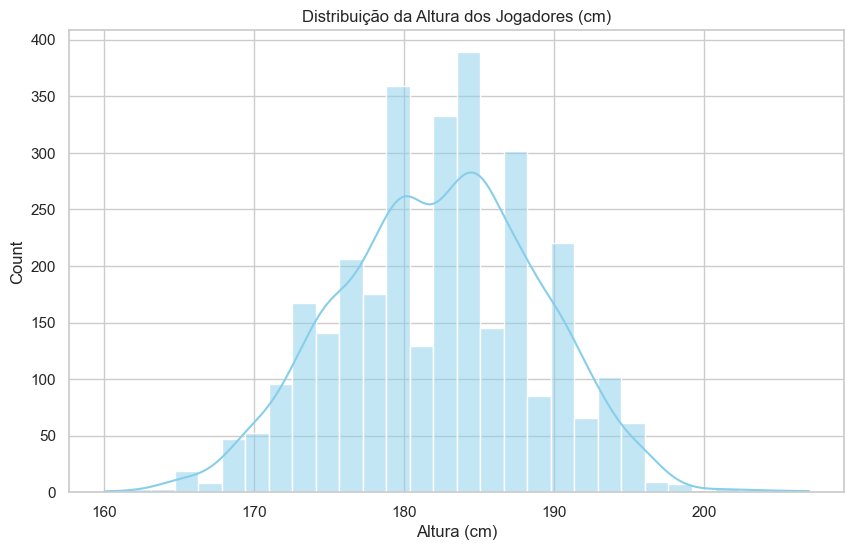

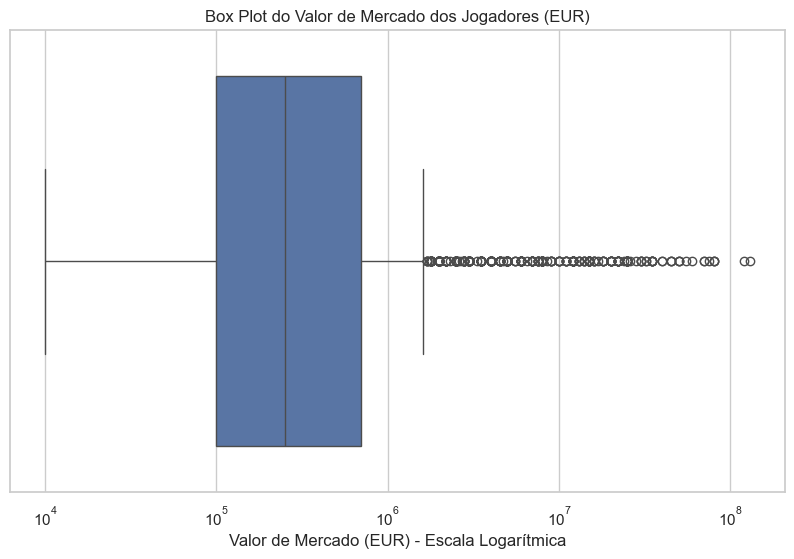

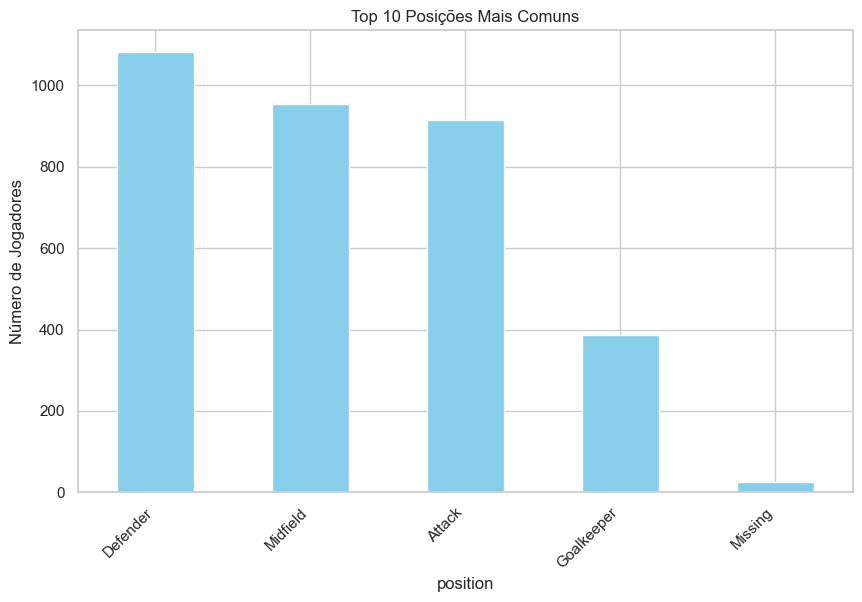

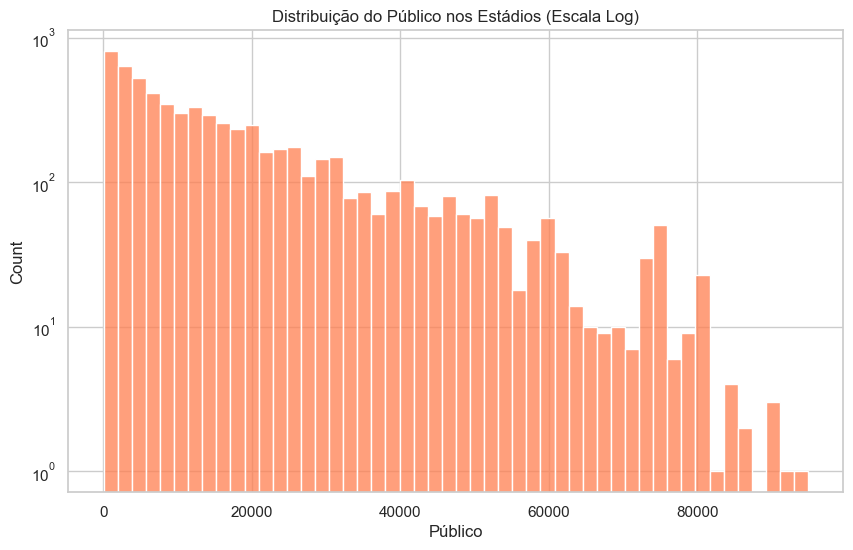

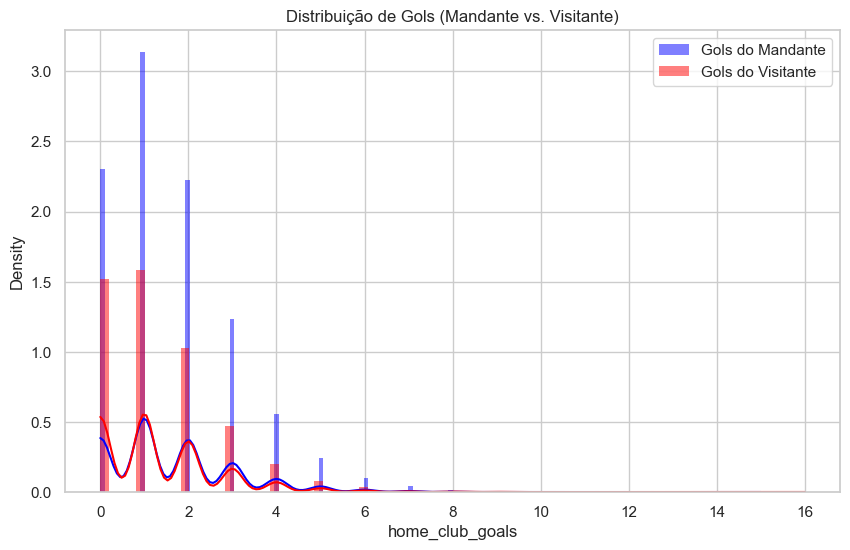

### Análise da Distribuição de Idade para: Jogadores

Calculamos a idade de cada jogador no momento da análise para entender o perfil demográfico do dataset.

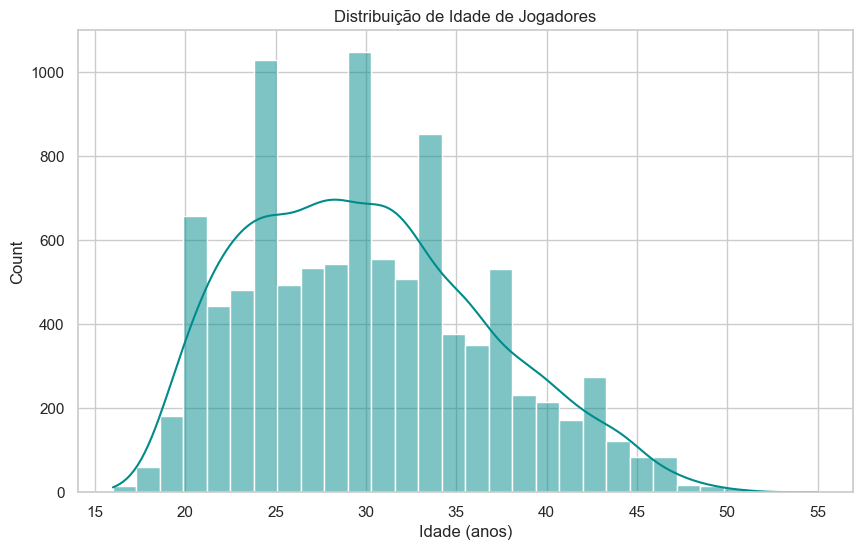

### Resumo Estatístico para: `Idade de Jogadores`

,age
summary,
count,"32,554.00"
mean,30.00
stddev,6.63
min,15.00
max,56.00


In [16]:

# 1. Histograma da Altura
plotar_histograma(
    series=players_pd_sample['height_in_cm'],
    titulo='Distribuição da Altura dos Jogadores (cm)',
    xlabel='Altura (cm)'
)

# 2. Box Plot do Valor de Mercado
plotar_boxplot(
    series=players_pd_sample['market_value_in_eur'],
    titulo='Box Plot do Valor de Mercado dos Jogadores (EUR)',
    xlabel='Valor de Mercado (EUR) - Escala Logarítmica',
    xscale='log'
)

# 3. Gráfico de Barras para Posição
plotar_barras_contagem(
    series=players_pd_sample['position'],
    titulo='Top 10 Posições Mais Comuns',
    ylabel='Número de Jogadores'
)

# 4. Histograma de Público
plotar_histograma(
    series=games_pd_sample['attendance'],
    titulo='Distribuição do Público nos Estádios (Escala Log)',
    xlabel='Público',
    bins=50,
    cor='coral',
    yscale='log',
    kde=False # KDE não faz muito sentido em escala log e com essa distribuição
)

# 5. Comparação de Gols (Casa vs. Visitante)
plotar_histogramas_comparativos(
    series1=games_pd_sample['home_club_goals'],
    label1='Gols do Mandante',
    cor1='blue',
    series2=games_pd_sample['away_club_goals'],
    label2='Gols do Visitante',
    cor2='red',
    titulo='Distribuição de Gols (Mandante vs. Visitante)'
)

# 6. Análise de Outliers na Idade dos Jogadores
analisar_distribuicao_idade(players_bronze, df_name="Jogadores")

--- Matriz de Correlação para: Jogadores ---


25/07/14 19:36:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


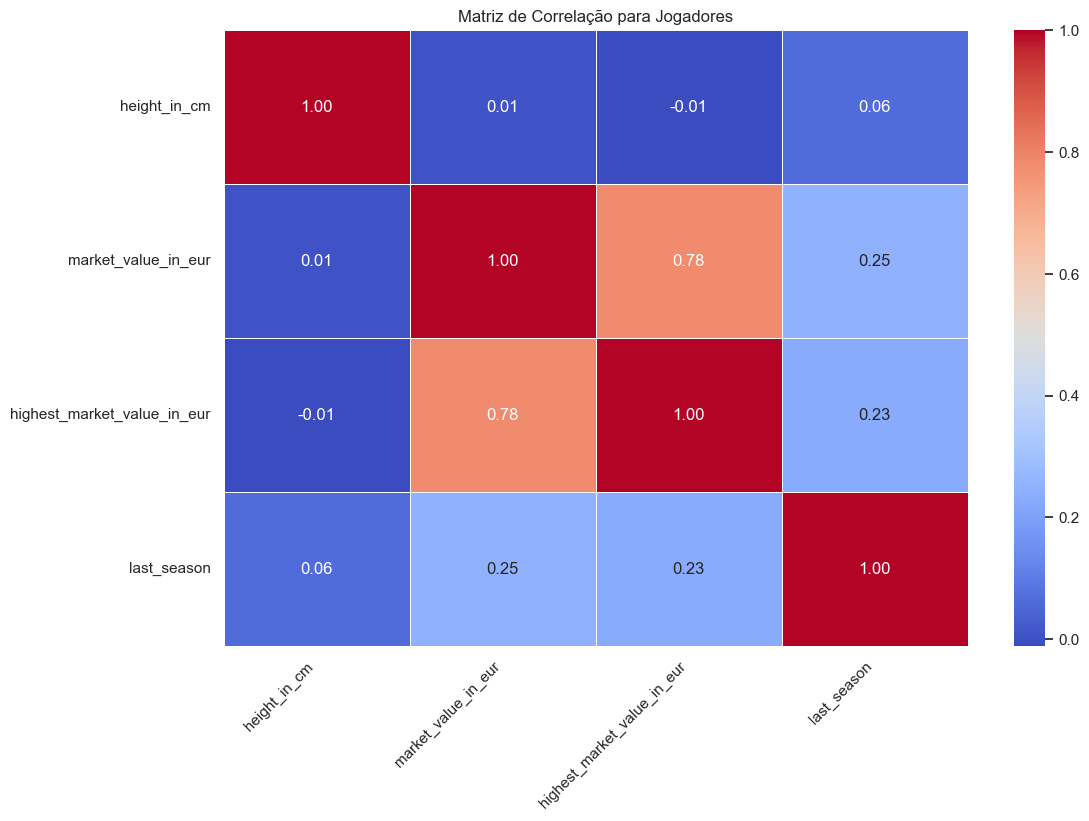



--- Matriz de Correlação para: Clubes ---


Não há dados suficientes para calcular a correlação após remover nulos.


In [17]:
# Análise para 'players_bronze'
colunas_players = ["height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "last_season"]
plotar_matriz_correlacao(players_bronze, colunas_players, "Jogadores")

# Análise para 'clubs_bronze'
# Primeiro, precisamos converter os valores em euros, como fizemos na camada Silver
clubs_bronze_for_corr = (clubs_bronze
                         .withColumn("total_market_value_eur", parse_euro("total_market_value"))
                         .withColumn("net_transfer_record_eur", parse_euro("net_transfer_record")))

colunas_clubs = ["squad_size", "average_age", "foreigners_number", "national_team_players", "stadium_seats", "total_market_value_eur", "net_transfer_record_eur"]
plotar_matriz_correlacao(clubs_bronze_for_corr, colunas_clubs, "Clubes")

--- Distribuição Categórica para: Jogadores [foot] ---


/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_14667/1527657222.py:271: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


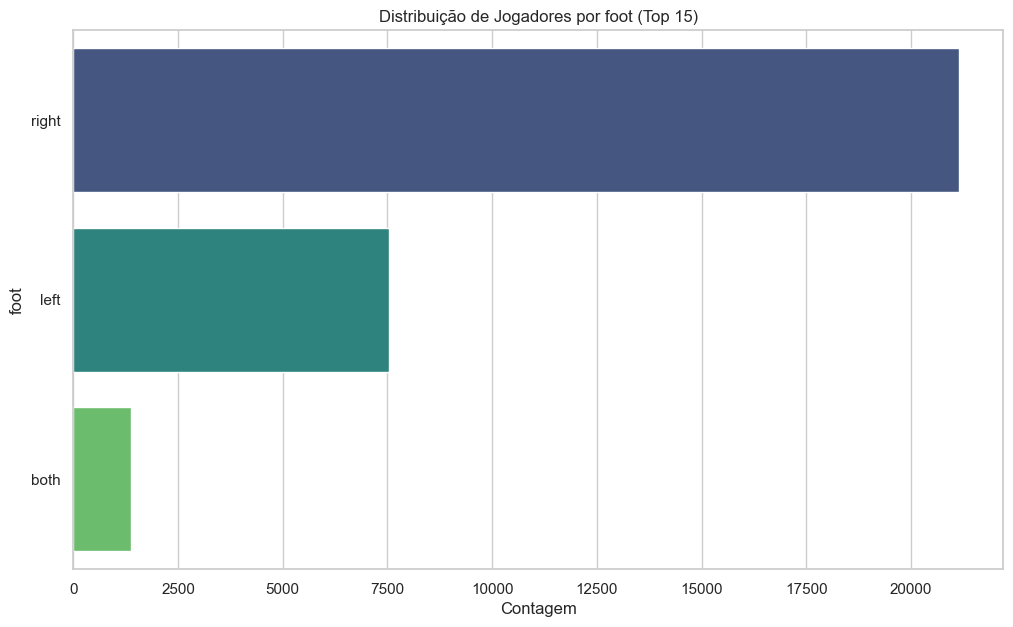



--- Distribuição Categórica para: Jogadores [sub_position] ---


/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_14667/1527657222.py:271: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


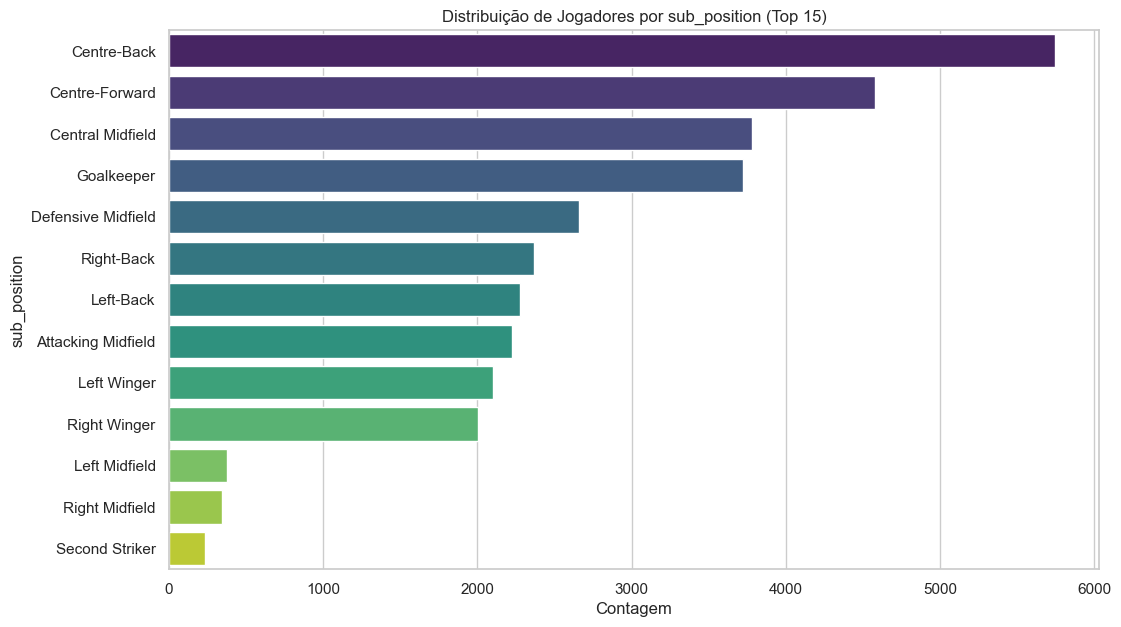



--- Distribuição Categórica para: Competições [confederation] ---


/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_14667/1527657222.py:271: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


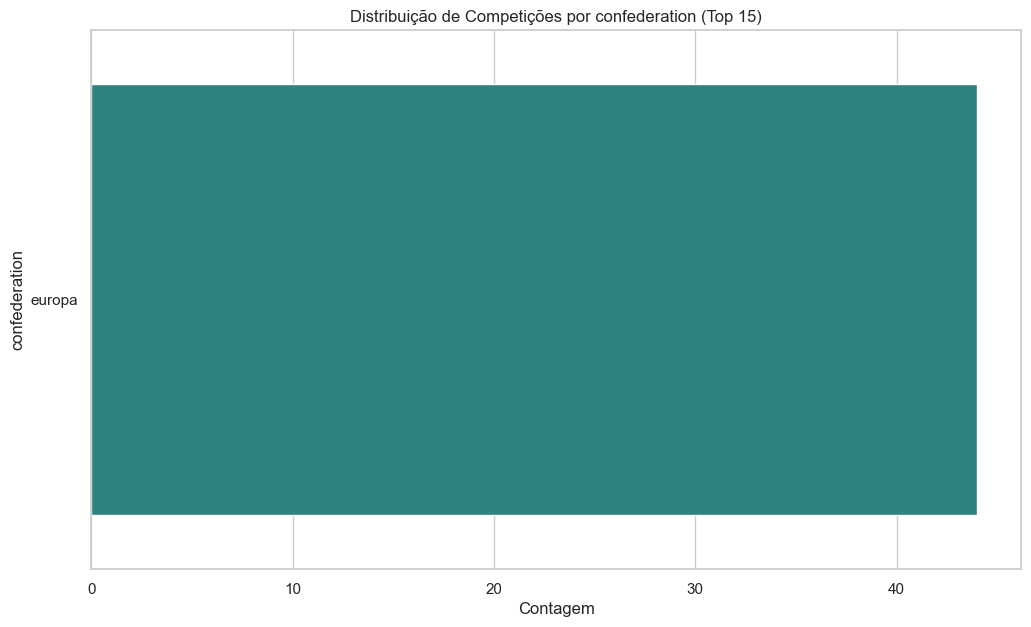

In [18]:
# Análise do pé dominante dos jogadores
plotar_distribuicao_categorica(players_bronze, "foot", "Jogadores")

# Análise da sub-posição dos jogadores
plotar_distribuicao_categorica(players_bronze, "sub_position", "Jogadores")

# Análise da confederação das competições
plotar_distribuicao_categorica(competitions_bronze, "confederation", "Competições")

In [47]:

# Identificar outliers no valor de mercado dos jogadores
identificar_outliers(players_bronze.filter("market_value_in_eur > 0"), "market_value_in_eur")

# Identificar outliers no público dos jogos
identificar_outliers(games_bronze.filter("attendance > 0"), "attendance")

### Análise de Outliers para a Coluna: `market_value_in_eur`


        - **Q1 (Primeiro Quartil):** `100000.0`
        - **Q3 (Terceiro Quartil):** `650000.0`
        - **IQR (Intervalo Interquartil):** `550000.0`
        - **Limite Inferior para Outliers:** `-725000.00`
        - **Limite Superior para Outliers:** `1475000.00`
        

⚠️ Encontrados **5015** outliers na coluna `market_value_in_eur`. Amostra:

,market_value_in_eur
0,200000000.0
1,200000000.0
2,180000000.0
3,180000000.0
4,170000000.0
5,150000000.0
6,140000000.0
7,140000000.0
8,130000000.0
9,130000000.0


### Análise de Outliers para a Coluna: `attendance`


        - **Q1 (Primeiro Quartil):** `4340.0`
        - **Q3 (Terceiro Quartil):** `26004.0`
        - **IQR (Intervalo Interquartil):** `21664.0`
        - **Limite Inferior para Outliers:** `-28156.00`
        - **Limite Superior para Outliers:** `58500.00`
        

⚠️ Encontrados **2776** outliers na coluna `attendance`. Amostra:

,attendance
0,99354
1,99354
2,98902
3,98761
4,98760
5,98485
6,98299
7,97939
8,97183
9,96973


--- Gerando Série Temporal: Evolução de Transferências por Temporada ---


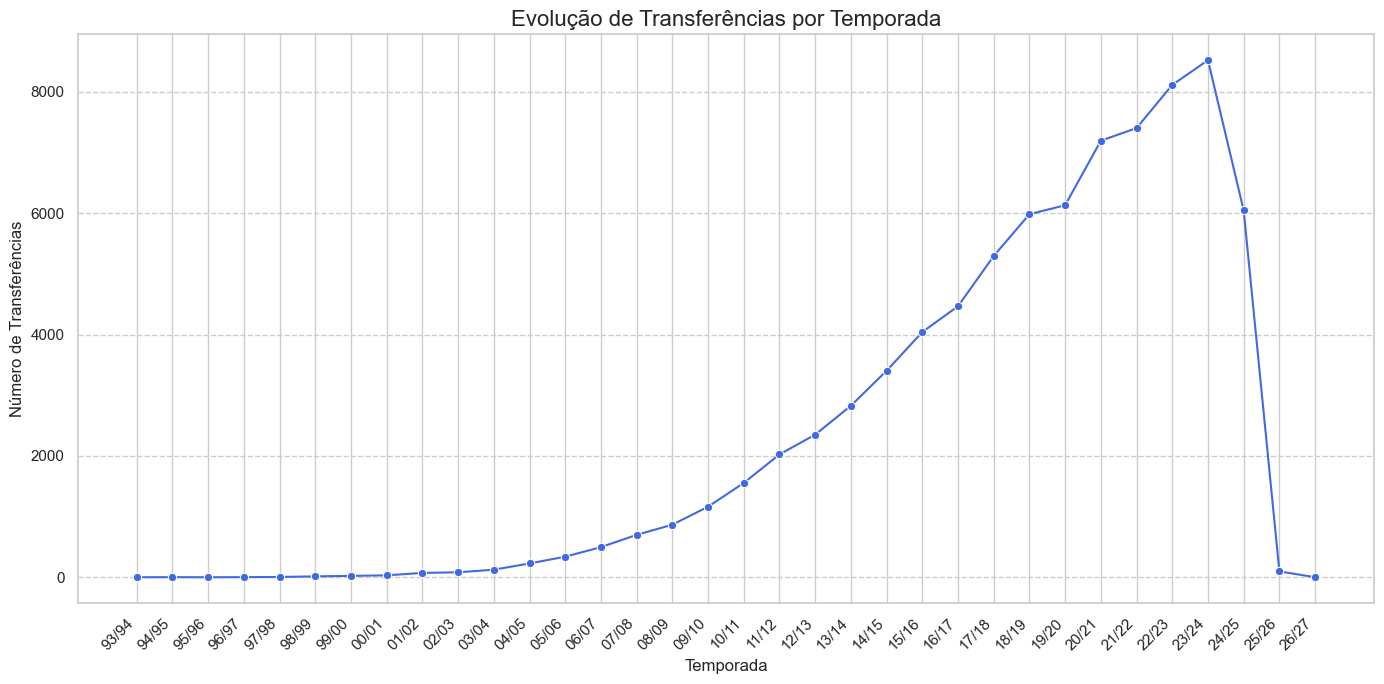



--- Gerando Série Temporal: Evolução do Valor de Mercado Médio dos Jogadores (EUR) ---


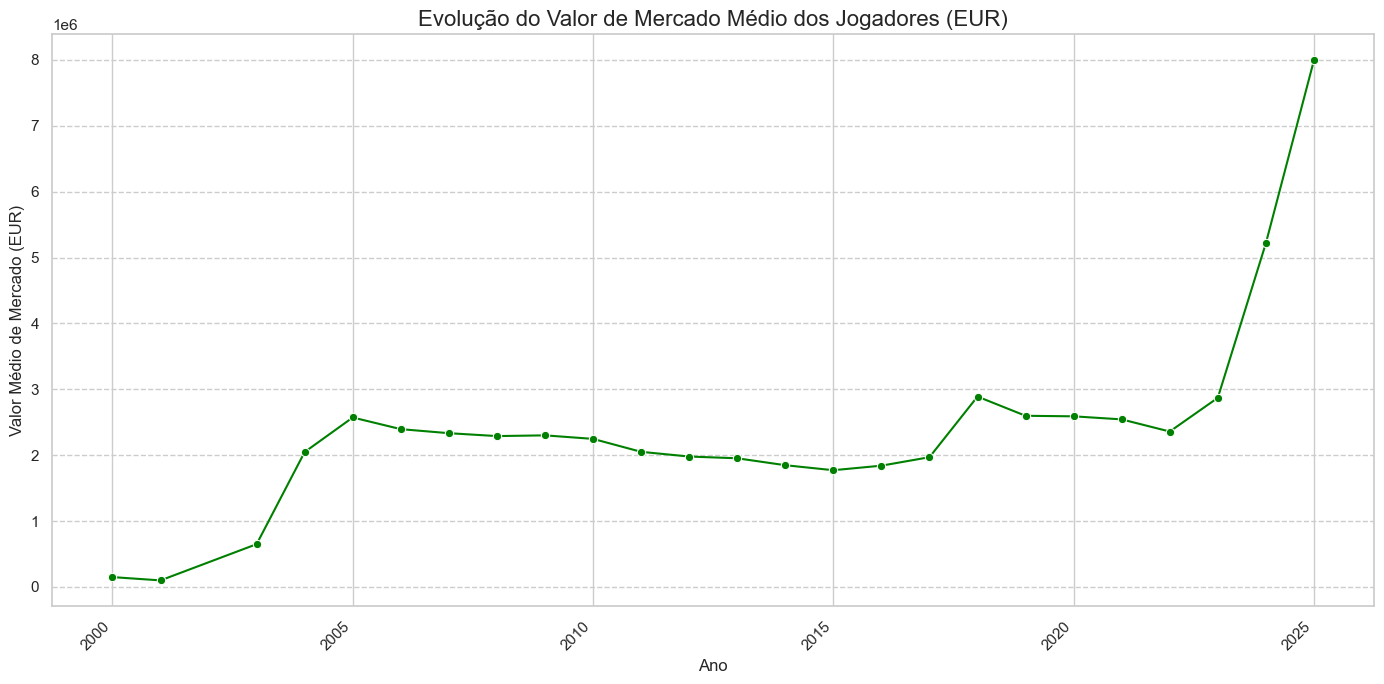

In [24]:
# 1. Evolução do número de transferências por temporada
plotar_serie_temporal(
    df=transfers_bronze,
    coluna_tempo='transfer_date',
    titulo='Evolução de Transferências por Temporada',
    xlabel='Temporada',
    ylabel='Número de Transferências',
    agregacao='count',
    unidade_tempo='season'   # <-- aqui
)

# 2. Evolução do valor de mercado médio ao longo do tempo
plotar_serie_temporal(
    df=valuations_bronze.filter("market_value_in_eur > 0"),
    coluna_tempo='date',
    titulo='Evolução do Valor de Mercado Médio dos Jogadores (EUR)',
    xlabel='Ano',
    ylabel='Valor Médio de Mercado (EUR)',
    agregacao='avg',
    coluna_valor='market_value_in_eur',
    unidade_tempo='year',
    cor='green'
)

---
### Camada Silver: Limpeza, Validação e Padronização

Com os insights da Análise Exploratória de Dados (EDA), transformamos a camada **Bronze** em uma camada **Silver** confiável e pronta para análise. Esta seção aplica um processo de limpeza e validação muito mais rigoroso, abordando diretamente os problemas de qualidade que identificamos.

As operações realizadas incluem:

1.  **Garantia de Integridade Referencial (Correção de Órfãos):**
    * A EDA revelou milhares de registros em `games` e alguns em `appearances` cujas chaves (`club_id`, `player_id`) não existiam nas tabelas principais (`clubs`, `players`).
    * Para corrigir isso, criamos conjuntos de IDs válidos e usamos `inner joins` para filtrar apenas os registros que possuem um relacionamento válido. Esta é a etapa mais crítica para garantir a consistência dos nossos `joins` futuros.

2.  **Tratamento Estratégico de Valores Nulos:**
    * **Preenchimento com 'Unknown' ou 'N/A':** Para colunas categóricas importantes com dados faltantes (como `foot`, `position`, `stadium`), preenchemos os nulos com um valor padrão. Isso evita a perda de registros e permite agrupar os dados desconhecidos.
    * **Preenchimento com Zero:** Para colunas numéricas onde `NULL` significa ausência de evento (como `goals`, `assists`, `attendance`), preenchemos com `0`.

3.  **Padronização e Criação de Features:**
    * **`parse_euro` (UDF):** A UDF que você criou é aplicada para converter colunas de texto com valores monetários (ex: `"+€3.05m"`) em um formato numérico (`double`).
    * **Cálculo de Idade:** Criamos uma coluna `age` na tabela `players_silver`, calculando a idade atual dos jogadores a partir de sua data de nascimento. Isso cria um atributo canônico e útil para as análises do Eixo 1.
    * **Cálculo de Valor de Mercado Agregado:** A EDA mostrou que a coluna `total_market_value` da tabela de clubes era inutilizável. Para contornar essa falha nos dados de origem, implementamos uma nova feature: o valor total de mercado de cada clube agora é **calculado pela soma do valor de mercado individual de todos os jogadores** do seu elenco. Usamos a função `coalesce` para garantir que nosso valor calculado preencha a lacuna de forma robusta.


4.  **Persistência em Delta Lake:**
    * Ao final do processo, cada tabela limpa e enriquecida é salva no formato Delta Lake. Isso cria um checkpoint robusto, otimiza a performance das consultas subsequentes e nos dá os benefícios de transações ACID e *time travel*.

In [20]:
print("Iniciando o processo de limpeza para a Camada Silver...")

# Garantir Integridade Referencial 
# Criamos conjuntos de IDs válidos das tabelas principais para usar como filtro
valid_player_ids = players_bronze.select("player_id").distinct()
valid_club_ids = clubs_bronze.select("club_id").distinct()
valid_game_ids = games_bronze.select("game_id").distinct()
valid_competition_ids = competitions_bronze.select("competition_id").distinct()

# Limpeza e Enriquecimento Tabela por Tabela 

# Tabela 'players': Calcular idade e tratar nulos
print("Limpando tabela 'players'...")
players_silver = (base_clean(players_bronze, ["player_id"])
                  .withColumn("age", F.floor(F.months_between(F.current_date(), F.col("date_of_birth")) / 12))
                  .na.fill("Unknown", subset=["foot", "position", "sub_position", "agent_name", "city_of_birth", "country_of_birth"])
                  .na.fill(0, subset=["height_in_cm"]))

#  Calcular o valor de mercado agregado por clube
print("Calculando o valor de mercado agregado por clube a partir dos jogadores...")
calculated_club_values = (players_silver
    .groupBy("current_club_id")
    .agg(
        F.sum("market_value_in_eur").alias("calculated_total_market_value"),
        F.count("player_id").alias("calculated_squad_size")
    )
)

# Tabela 'clubs': Aplicar UDF, tratar nulos e inserir com o valor calculado.
print("Limpando e inserindo valores na tabela 'clubs'...")
clubs_silver = (base_clean(clubs_bronze, ["club_id"])
                # Parsing inicial das colunas de texto
                .withColumn("total_market_value_eur_parsed", parse_euro(F.col("total_market_value")))
                .withColumn("net_transfer_record_eur", parse_euro(F.col("net_transfer_record")))
                .drop("total_market_value", "net_transfer_record", "filename")
                # Join com os valores calculados
                .join(calculated_club_values, F.col("club_id") == F.col("current_club_id"), "left")
                # Cria a coluna final, usando o valor calculado se o original for nulo
                .withColumn("total_market_value_eur", 
                    F.coalesce(F.col("total_market_value_eur_parsed"), F.col("calculated_total_market_value"))
                )
                # Limpeza final das colunas intermediárias
                .drop("total_market_value_eur_parsed", "calculated_total_market_value", "calculated_squad_size", "current_club_id")
                # Tratamento de nulos para outras colunas
                .na.fill(0, subset=["squad_size", "average_age", "foreigners_number", "national_team_players", "stadium_seats"])
                .na.fill("Unknown", subset=["stadium_name", "coach_name"]))


# Tabela 'games': Filtrar registros órfãos e tratar nulos
print("Limpando tabela 'games'...")
games_silver = (base_clean(games_bronze, ["game_id"])
                # Garante que ambos os clubes do jogo existem na tabela de clubes
                .join(valid_club_ids.withColumnRenamed("club_id", "home_club_id"), "home_club_id", "inner")
                .join(valid_club_ids.withColumnRenamed("club_id", "away_club_id"), "away_club_id", "inner")
                .na.fill(0, subset=["attendance"])
                .na.fill("Unknown", subset=["stadium", "referee", "home_club_manager_name", "away_club_manager_name", "home_club_formation", "away_club_formation"]))

# Tabela 'appearances': Filtrar registros órfãos e tratar nulos
print("Limpando tabela 'appearances'...")
apps_silver = (base_clean(apps_bronze, ["appearance_id"])
               # Garante que o jogador e o jogo da "aparição" realmente existem
               .join(valid_player_ids, "player_id", "inner")
               .join(valid_game_ids, "game_id", "inner")
               .na.fill(0, subset=["yellow_cards", "red_cards", "goals", "assists", "minutes_played"])
               .filter(F.col("minutes_played") > 0)) # Mantém apenas jogadores que de fato jogaram

# Limpeza básica para as demais tabelas (pode ser expandida conforme necessidade)
print("Limpando tabelas restantes...")
valuations_silver = base_clean(valuations_bronze, ["player_id", "date"])
transfers_silver = base_clean(transfers_bronze, ["player_id", "transfer_date"]).na.fill(0, subset=["transfer_fee", "market_value_in_eur"])
club_games_silver = base_clean(club_games_bronze, ["game_id", "club_id"])
competitions_silver = base_clean(competitions_bronze, ["competition_id"])
events_silver = base_clean(events_bronze, ["game_event_id"])
lineups_silver = base_clean(lineups_bronze, ["game_lineups_id"])

# Persistir Tabelas Silver como Delta 
silver_tables = {
    "apps": apps_silver,
    "clubs": clubs_silver,
    "games": games_silver,
    "players": players_silver,
    "valuations": valuations_silver,
    "transfers": transfers_silver,
    "club_games": club_games_silver,
    "competitions": competitions_silver,
    "events": events_silver,
    "lineups": lineups_silver
}

print("\nIniciando a persistência das tabelas Silver em formato Delta...")
for name, df in silver_tables.items():
    target_path = f"{PATH}/{name}"
    print(f"Salvando tabela '{name}' em {target_path}...")
    (df.write
       .mode("overwrite")
       .format("delta")
       .option("overwriteSchema", "true") 
       .save(target_path))

print("\n✅ Processo de criação da Camada Silver concluído com sucesso!")

Iniciando o processo de limpeza para a Camada Silver...
Limpando tabela 'players'...
Calculando o valor de mercado agregado por clube a partir dos jogadores...
Limpando e inserindo valores na tabela 'clubs'...
Limpando tabela 'games'...
Limpando tabela 'appearances'...
Limpando tabelas restantes...

Iniciando a persistência das tabelas Silver em formato Delta...
Salvando tabela 'apps' em ./pre-processing/apps...


25/07/14 19:36:55 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'clubs' em ./pre-processing/clubs...


Salvando tabela 'games' em ./pre-processing/games...


25/07/14 19:37:25 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'players' em ./pre-processing/players...


25/07/14 19:37:37 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'valuations' em ./pre-processing/valuations...


25/07/14 19:37:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'transfers' em ./pre-processing/transfers...


Salvando tabela 'club_games' em ./pre-processing/club_games...


25/07/14 19:38:08 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'competitions' em ./pre-processing/competitions...


Salvando tabela 'events' em ./pre-processing/events...


25/07/14 19:38:25 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers


Salvando tabela 'lineups' em ./pre-processing/lineups...


25/07/14 19:38:47 WARN MemoryManager: Total allocation exceeds 95,00% (1.020.054.720 bytes) of heap memory
Scaling row group sizes to 95,00% for 8 writers



✅ Processo de criação da Camada Silver concluído com sucesso!


### Verificação Pós-Limpeza 

Nesta seção, realizamos uma auditoria nos dados da camada Silver para garantir que nosso processo de limpeza e transformação foi bem-sucedido. O objetivo é validar programaticamente que os problemas de qualidade de dados identificados na análise exploratória foram corrigidos.

Realizamos três tipos de verificação:
1.  **Re-checagem da Integridade Referencial:** Repetimos os testes para garantir que não existem mais registros órfãos.
2.  **Re-análise de Nulos:** Verificamos as colunas que tratamos para confirmar que os valores nulos foram preenchidos.
3.  **Amostragem Visual:** Exibimos uma amostra dos DataFrames transformados para confirmar visualmente a aplicação de novas colunas (como `age`) e a conversão de tipos de dados.

In [21]:
print("Resultados da Limpeza e Transformação:")

# Re-checagem da Integridade Referencial
# Esperamos que agora o resultado para todas as checagens seja "Nenhuma inconsistência encontrada"
print("\n" + "="*40)
print("RE-VERIFICANDO INTEGRIDADE REFERENCIAL")
print("="*40)
checar_integridade(clubs_silver, "club_id", games_silver, "home_club_id", "clubs_silver -> games_silver (home)")
checar_integridade(players_silver, "player_id", apps_silver, "player_id", "players_silver -> apps_silver")

# Re-análise de Valores Nulos
# Verificamos se as colunas que tratamos agora não possuem mais nulos
print("\n" + "="*40)
print("RE-ANALISANDO VALORES NULOS EM TABELAS CRÍTICAS")
print("="*40)
analisar_nulos(players_silver, "players_silver")
analisar_nulos(games_silver, "games_silver")

# Amostragem Visual das Transformações
# Exibimos amostras para confirmar que as novas colunas foram criadas e os tipos convertidos
print("\n" + "="*40)
print("AMOSTRA DOS DADOS TRANSFORMADOS")
print("="*40)

print("\nJogadores com idade calculada e nulos tratados em 'foot' e 'position':")
(players_silver
    .select("name", "age", "date_of_birth", "foot", "position")
    .show(5, truncate=False))

print("\nClubes com valores monetários convertidos para numérico:")
(clubs_silver
    .select("name", "total_market_value_eur", "net_transfer_record_eur")
    .show(5, truncate=False))

print("\nAparições com estatísticas preenchidas e filtro de minutos jogados aplicado:")
(apps_silver
    .select("appearance_id", "player_name", "goals", "assists", "minutes_played")
    .show(5, truncate=False))

print("\n✅ Verificação da Camada Silver concluída.")

Resultados da Limpeza e Transformação:

RE-VERIFICANDO INTEGRIDADE REFERENCIAL


### Verificação de Integridade Referencial: `clubs_silver -> games_silver (home)`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.

### Verificação de Integridade Referencial: `players_silver -> apps_silver`

✅ **Tudo certo!** Nenhuma inconsistência de integridade referencial foi encontrada.




RE-ANALISANDO VALORES NULOS EM TABELAS CRÍTICAS


### Análise de Nulos para: `players_silver`

Resultados para **32601** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,contract_expiration_date,12091,37.09
1,first_name,2062,6.32
2,market_value_in_eur,1523,4.67
3,highest_market_value_in_eur,1523,4.67
4,country_of_citizenship,383,1.17
5,date_of_birth,47,0.14
6,age,47,0.14


### Análise de Nulos para: `games_silver`

Resultados para **58486** linhas:

,Coluna,Contagem de Nulos,Percentual (%)
0,home_club_position,6927,11.84
1,away_club_position,6927,11.84





AMOSTRA DOS DADOS TRANSFORMADOS

Jogadores com idade calculada e nulos tratados em 'foot' e 'position':
+------------------+---+-------------------+-------+----------+
|name              |age|date_of_birth      |foot   |position  |
+------------------+---+-------------------+-------+----------+
|Miroslav Klose    |47 |1978-06-09 00:00:00|right  |Attack    |
|Roman Weidenfeller|44 |1980-08-06 00:00:00|left   |Goalkeeper|
|Dimitar Berbatov  |44 |1981-01-30 00:00:00|Unknown|Attack    |
|Lúcio             |47 |1978-05-08 00:00:00|Unknown|Defender  |
|Tom Starke        |44 |1981-03-18 00:00:00|right  |Goalkeeper|
+------------------+---+-------------------+-------+----------+
only showing top 5 rows

Clubes com valores monetários convertidos para numérico:
+-------------------------+----------------------+-----------------------+
|name                     |total_market_value_eur|net_transfer_record_eur|
+-------------------------+----------------------+-----------------------+
|1.FC Köln

+--------------+-------------------+-----+-------+--------------+
|appearance_id |player_name        |goals|assists|minutes_played|
+--------------+-------------------+-----+-------+--------------+
|2211607_111184|Dico Koppers       |0    |0      |14            |
|2211607_34784 |Lasse Schöne       |0    |0      |25            |
|2211607_4338  |Wilfred Bouma      |0    |0      |90            |
|2211607_45509 |Siem de Jong       |0    |0      |90            |
|2211607_49499 |Georginio Wijnaldum|1    |0      |16            |
+--------------+-------------------+-----+-------+--------------+
only showing top 5 rows

✅ Verificação da Camada Silver concluída.


---
### Modelagem para os Eixos de Análise

Com os dados limpos e persistidos na camada Silver, iniciamos a fase de **Engenharia de Atributos** e modelagem. Aqui, aplicamos a lógica de negócio para criar os DataFrames que responderão diretamente às perguntas definidas nos três eixos do projeto.

* **Eixo 1 (Valor de Mercado e ROI):**
    * No DataFrame `valuations_enriched`, utilizamos **funções de janela** (`Window`) para calcular a idade do jogador em cada data de avaliação e a variação percentual de valor (`pct_growth`) em relação à medição anterior.
    * No DataFrame `roi`, unimos dados de transferências e de valorações para calcular um ROI (Retorno sobre Investimento) simplificado, medindo a valorização do atleta nos 12 meses seguintes à sua contratação.

* **Eixo 2 (Impacto Tático):**
    * O DataFrame `apps_enriched` é enriquecido com informações de contexto do jogo (se o jogador estava em casa ou fora, se foi titular ou substituto).
    * `tactical_impact` agrega essas informações por jogador para criar métricas de desempenho médio, como média de gols, assistências e taxa de participação como substituto.

* **Eixo 3 (Carreira e Conexões):**
    * O DataFrame `career_edges` é preparado especificamente para o Neo4j. Ele isola as informações de transferência, formatando os dados para representar as **arestas** (relações `TRANSFERRED_TO`) do nosso futuro grafo de carreiras.


Estruturação Eixo 1

In [22]:
w_date = Window.partitionBy("player_id").orderBy("date")

valuations_enriched = (valuations_silver
                       .join(players_silver.select("player_id","date_of_birth"), "player_id")
                       .withColumn("age",
                                   F.floor(F.months_between("date","date_of_birth")/12))
                       .withColumn("prev_value",
                                   F.lag("market_value_in_eur").over(w_date))
                       .withColumn("pct_growth",
                                   (F.col("market_value_in_eur")-F.try_divide(F.col("prev_value"), F.col("prev_value")))))

# ROI de transferências (simples: variação de valor em 12 meses após compra)
buy_side = (transfers_silver
            .select("player_id","transfer_date","to_club_id","transfer_fee")
            .withColumnRenamed("transfer_date","buy_date"))

roi = (buy_side
       .join(valuations_enriched, (valuations_enriched.player_id == buy_side.player_id) &
                                  (valuations_enriched.date >= buy_side.buy_date) &
                                  (valuations_enriched.date <= F.add_months(buy_side.buy_date,12)))
       .groupBy(buy_side.player_id, "to_club_id","transfer_fee")
       .agg(F.max("market_value_in_eur").alias("value_after_12m"))
       .withColumn("roi_pct",
                   (F.col("value_after_12m")-F.try_divide(F.col("transfer_fee"), F.col("transfer_fee")))))

---
Estruturação Eixo 2

In [27]:
apps_enriched = (apps_silver
                 .join(games_silver.select("game_id","home_club_id","away_club_id",
                                           "home_club_goals","away_club_goals"),"game_id")
                 .withColumn("is_home",
                             F.when(F.col("player_club_id")==F.col("home_club_id"),1).otherwise(0))
                 .withColumn("is_sub",
                             F.when((F.col("minutes_played")<90) & (F.col("minutes_played")>0),1).otherwise(0))
                )

tactical_impact = (apps_enriched
                   .groupBy("player_id")
                   .agg(F.avg("goals").alias("avg_goals"),
                        F.avg("assists").alias("avg_assists"),
                        F.avg("is_sub").alias("sub_rate")))

# Agregamos os eventos de cada jogo em um array
events_agg = (events_silver
    .groupBy("game_id")
    .agg(F.collect_list(
        F.struct(
            "minute",
            F.col("type").alias("event_type"),
            "club_id",
            "player_id",
            "player_in_id",
            "player_assist_id"
        )
    ).alias("events"))
)

# Agregamos as escalações de cada jogo em um array
lineups_agg = (lineups_silver
    .groupBy("game_id")
    .agg(F.collect_list(
        F.struct(
            "player_id",
            "club_id",
            "player_name",
            F.col("type").alias("lineup_type"), # starting_lineup vs substitutes
            "position"
        )
    ).alias("lineup"))
)



# Criamos o documento final do jogo, juntando tudo
print("Construindo o documento final do jogo para o MongoDB...")
games_doc = (games_silver
    .join(events_agg, "game_id", "left")
    .join(lineups_agg, "game_id", "left")
    .drop("_ingest_timestamp")
)

print("Schema do documento de jogo a ser carregado:")
games_doc.printSchema()

Construindo o documento final do jogo para o MongoDB...
Schema do documento de jogo a ser carregado:
root
 |-- game_id: long (nullable = true)
 |-- away_club_id: long (nullable = true)
 |-- home_club_id: long (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- round: string (nullable = true)
 |-- date: date (nullable = true)
 |-- home_club_goals: integer (nullable = true)
 |-- away_club_goals: integer (nullable = true)
 |-- home_club_position: integer (nullable = true)
 |-- away_club_position: integer (nullable = true)
 |-- home_club_manager_name: string (nullable = false)
 |-- away_club_manager_name: string (nullable = false)
 |-- stadium: string (nullable = false)
 |-- attendance: integer (nullable = true)
 |-- referee: string (nullable = false)
 |-- url: string (nullable = true)
 |-- home_club_formation: string (nullable = false)
 |-- away_club_formation: string (nullable = false)
 |-- home_club_name: string (nullable = true)
 

---
Estruturação Eixo 3

In [34]:
career_edges = (transfers_silver
                .filter(F.col("from_club_id").isNotNull())
                .select("player_id", "from_club_id", "to_club_id", F.col("transfer_date").alias("date"), "transfer_fee"))

clubs_neo4j = (clubs_silver
    .join(
        competitions_silver.select("competition_id", "country_name"),
        clubs_silver.domestic_competition_id == competitions_silver.competition_id,
        "left"
    )
    .select(
        F.col("club_id").alias("id"),
        F.col("name"),
        F.col("country_name").alias("country")
    )
    .na.fill("Unknown", subset=["country"])
)

### Carga no MongoDB

Nesta etapa final do pipeline de ETL, materializamos nossos dados enriquecidos da camada Silver no **MongoDB**. A estratégia adotada foi criar duas coleções distintas, cada uma modelada para otimizar as consultas de um eixo específico do nosso projeto, aproveitando a flexibilidade do modelo de documentos.

---

#### Coleção `players`: O Perfil 360° do Jogador

O DataFrame `players_doc` é carregado na coleção `players`. Ele é construído como um **documento denormalizado**, agregando, para cada jogador, um conjunto rico de informações. Esta estrutura é ideal para as análises dos **Eixos 1 e 2**.

Cada documento contém:
* Dados pessoais e físicos (do `players_silver`).
* Métricas de desempenho tático agregadas, como média de gols e assistências (do `tactical_impact`).
* Um **array aninhado** com o histórico completo de suas **valorações de mercado**, incluindo a idade do jogador em cada ponto.
* Um **array aninhado** com o histórico de suas **transferências**, incluindo taxas e clubes.

Essa estrutura de "Perfil 360°" é extremamente eficiente, pois permite recuperar a carreira completa de um jogador com uma única consulta, eliminando a necessidade de `JOINs` complexos no momento da leitura.

---

#### Coleção `games`: O Documento de Jogo Completo

O DataFrame `games_doc` é carregado na coleção `games` e foi projetado especificamente para as análises táticas do **Eixo 2**.

Cada documento representa uma única partida e contém:
* Dados principais do jogo (resultado, data, estádio, formações táticas).
* Um **array aninhado `lineup`** com todos os jogadores que participaram da partida, indicando se foram titulares (`starting_lineup`) ou substitutos (`substitutes`).
* Um **array aninhado `events`** com todos os eventos que ocorreram no jogo (gols, cartões, substituições), incluindo o minuto de cada evento.

Manter todo o contexto de uma partida em um único documento facilita a análise de padrões de eventos e o impacto de decisões táticas, como substituições.

In [33]:
# Agregamos as transferências por jogador
player_transfers_agg = (transfers_silver
    .groupBy("player_id")
    .agg(F.collect_list(
        F.struct(
            "transfer_date",
            "from_club_name",
            "to_club_name",
            "transfer_fee"
        )
    ).alias("transfers"))
)

# Construção do DataFrame 'players_doc' com um array de 'valuations' E 'transfers'
print("Construindo o documento final e enriquecido do jogador para o MongoDB...")
players_doc = (players_silver
               .join(tactical_impact, "player_id", "left")
               .join(
                   valuations_enriched.groupBy("player_id")
                     .agg(F.collect_list(
                         F.struct("date", "age", "market_value_in_eur", "pct_growth")
                     ).alias("valuations")),
                   "player_id", "left"
               )
               # Adicionamos o histórico de transferências 
               .join(player_transfers_agg, "player_id", "left")
               .join(clubs_silver.select("club_id", F.col("name").alias("current_club_name")), 
                     F.col("current_club_id") == F.col("club_id"), "left")
               .drop("current_club_id", "club_id")
               .drop("_ingest_timestamp")
)

print("Iniciando a carga dos documentos enriquecidos no MongoDB...")
(players_doc
 .write
 .format("mongodb")
 .option("collection","players")
 .mode("overwrite")
 .save())

print("Iniciando a carga da coleção 'games' no MongoDB...")

(games_doc
#  .limit(10000)
 .write
 .format("mongodb")
 .option("collection", "games") 
 .mode("overwrite")
 .save())


print("✅ Carga no MongoDB concluída com sucesso!")

Construindo o documento final e enriquecido do jogador para o MongoDB...
Iniciando a carga dos documentos enriquecidos no MongoDB...


Iniciando a carga da coleção 'games' no MongoDB...


✅ Carga no MongoDB concluída com sucesso!


---
### Carga no Neo4j

Aqui, populamos nosso banco de dados de grafos **Neo4j**. Este modelo é naturalmente adequado para representar e analisar as conexões e trajetórias na carreira dos atletas. O processo é dividido em duas partes:

1.  **Criação dos Nós:**
    * Os `:Player` (nós de jogador) são criados a partir do `players_silver`.
    * Os `:Club` (nós de clube) são criados a partir do `clubs_silver`.
    * Utilizamos a opção `.option("node.keys", "id")` para garantir a **idempotência**, ou seja, que um mesmo jogador ou clube não seja criado mais de uma vez, mesmo que o código seja executado múltiplas vezes.

2.  **Criação das Arestas:**
    * As relações `:TRANSFERRED_TO` são criadas a partir do DataFrame `career_edges`.
    * O conector do Spark mapeia as colunas de origem (`source_id`) e de destino (`target_id`) para conectar os nós `:Player` e `:Club` correspondentes, criando o grafo que representa as transferências.

In [35]:
# Carregando as tabelas Silver do Delta Lake
print("Carregando tabelas da camada Silver...")
players_silver = spark.read.format("delta").load(f"{PATH}/players")
clubs_silver = spark.read.format("delta").load(f"{PATH}/clubs")
transfers_silver = spark.read.format("delta").load(f"{PATH}/transfers")
competitions_silver = spark.read.format("delta").load(f"{PATH}/competitions")


# Carga dos nós
print("Iniciando a carga dos nós no Neo4j...")

# Nós: Player
(players_silver
  .selectExpr("player_id as id", "name", "age", "position")
  .write
  .format("org.neo4j.spark.DataSource")
  .option("labels", ":Player")
  .option("node.keys", "id")
  .option("url", NEO4J_URL) # Adicionando configs para execução isolada
  .option("authentication.type", "basic")
  .option("authentication.basic.username", NEO4J_AUTH[0])
  .option("authentication.basic.password", NEO4J_AUTH[1])
  .mode("overwrite")
  .save())

# Nós: Club
(clubs_neo4j
  .write
  .format("org.neo4j.spark.DataSource")
  .option("labels", ":Club")
  .option("node.keys", "id")
  .option("url", NEO4J_URL)
  .option("authentication.type", "basic")
  .option("authentication.basic.username", NEO4J_AUTH[0])
  .option("authentication.basic.password", NEO4J_AUTH[1])
  .mode("overwrite")
  .save())

print("✅ Carga de Nós concluída.")

# Carga das arestas de transferência
print("Iniciando a carga das arestas de transferência no Neo4j...")
career_edges = (transfers_silver
                .filter(F.col("from_club_id").isNotNull()) 
                .select("player_id", "from_club_id", "to_club_id", F.col("transfer_date").alias("date"), "transfer_fee"))

# Arestas: (Player)-[:TRANSFERRED_TO]->(Club)
(career_edges
   .selectExpr("player_id as source_id", "to_club_id as target_id", "date", "transfer_fee")
   .write
   .format("org.neo4j.spark.DataSource")
   .option("relationship", "TRANSFERRED_TO")
   .option("relationship.save.strategy", "keys")
   .option("relationship.source.labels", ":Player")
   .option("relationship.source.node.keys", "source_id:id")
   .option("relationship.target.labels", ":Club")
   .option("relationship.target.node.keys", "target_id:id")
   .option("url", NEO4J_URL)
   .option("authentication.type", "basic")
   .option("authentication.basic.username", NEO4J_AUTH[0])
   .option("authentication.basic.password", NEO4J_AUTH[1])
   .mode("append")
   .save())

# Arestas: (Player)-[:TRANSFERRED_FROM]->(Club)
(career_edges
   .selectExpr("player_id as source_id", "from_club_id as target_id", "date", "transfer_fee")
   .write
   .format("org.neo4j.spark.DataSource")
   .option("relationship", "TRANSFERRED_FROM")
   .option("relationship.save.strategy", "keys")
   .option("relationship.source.labels", ":Player")
   .option("relationship.source.node.keys", "source_id:id")
   .option("relationship.target.labels", ":Club")
   .option("relationship.target.node.keys", "target_id:id")
   .option("url", NEO4J_URL)
   .option("authentication.type", "basic")
   .option("authentication.basic.username", NEO4J_AUTH[0])
   .option("authentication.basic.password", NEO4J_AUTH[1])
   .mode("append")
   .save())

print("✅ Carga de Arestas concluída.")

Carregando tabelas da camada Silver...
Iniciando a carga dos nós no Neo4j...


✅ Carga de Nós (:Player, :Club) concluída.
Iniciando a carga das arestas de transferência no Neo4j...


✅ Carga de Arestas (:TRANSFERRED_TO, :TRANSFERRED_FROM) concluída.


---
# Consultas

# Eixo 1: Análise do Valor de Mercado 

Nesta seção, iniciamos a fase de análise de dados, focando nas perguntas do **Eixo 1: Evolução do Valor de Mercado de Jogadores e Impacto das Transferências**. Para isso, vamos extrair os dados diretamente do **MongoDB**, que foi populado com os perfis enriquecidos dos jogadores na etapa anterior.

A escolha do MongoDB para esta análise é estratégica. O modelo de documentos nos permite armazenar o histórico de valorações de cada jogador como um array aninhado dentro de um único documento ("Perfil 360°"). Isso torna as consultas que analisam a evolução temporal, como as que faremos a seguir, extremamente eficientes, pois evitam a necessidade de `JOINs` complexos.

Utilizaremos o **Aggregation Pipeline** do MongoDB para realizar as seguintes análises:

1.  **Correlação entre Idade, Desempenho e Valorização:** Investigaremos a "curva de valorização" de um jogador, buscando entender como a idade e uma métrica de desempenho (média de gols) se correlacionam com o valor de mercado. A análise usará um `$unwind` para processar cada registro de valoração individualmente e calculará a idade do jogador naquele momento específico.

2.  **Identificação de Clubes que Valorizam Atletas:** Buscaremos identificar quais clubes são mais eficazes em aumentar o valor de mercado de seus jogadores. A consulta calculará o crescimento percentual do valor de um jogador ao longo de um período significativo em um clube e, em seguida, agregará esses dados para criar um ranking.

As saídas dessas consultas serão convertidas para DataFrames Pandas para a criação de visualizações com `Matplotlib` e `Seaborn`.

---

Analisando a correlação entre a idade de um jogador, sua média de gols e seu valor de mercado.

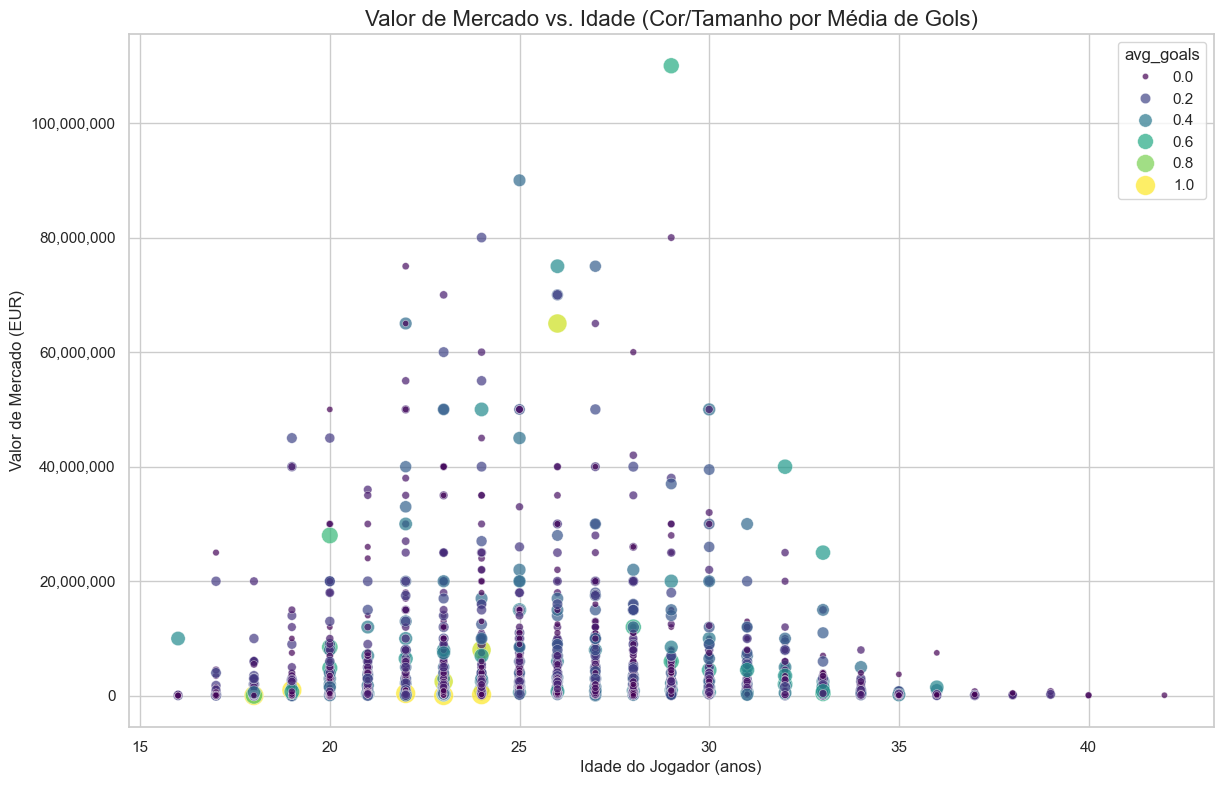

---

Identificando os clubes associados aos maiores saltos de valorização de jogadores.

#### Top 10 Clubes por Média de Crescimento Percentual de Valor

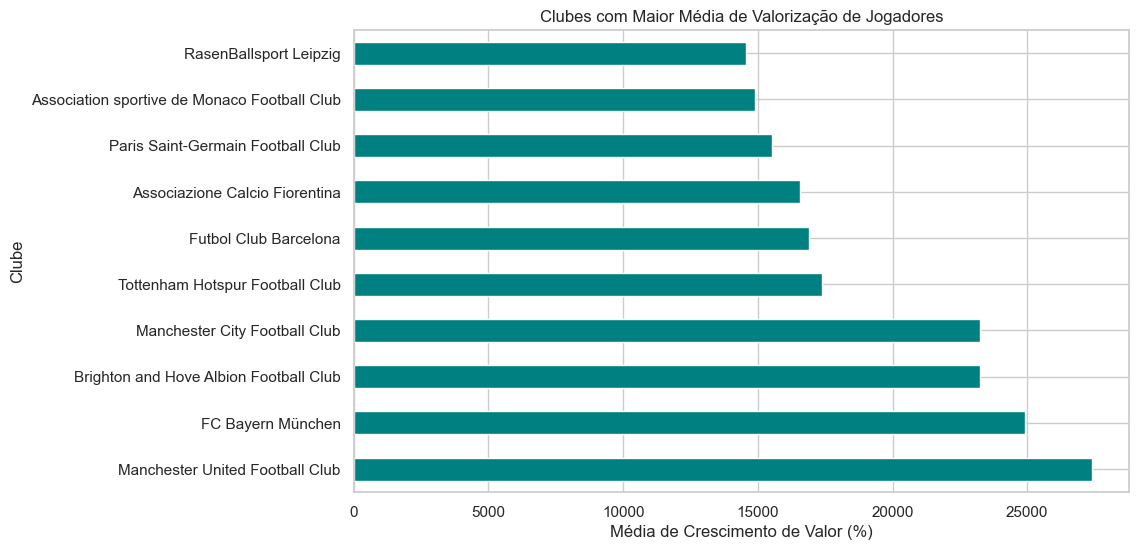

---

Calculando o Retorno sobre o Investimento para o clube comprador em cada transferência de Romelu Lukaku.

#### Análise de ROI para as Transferências de Romelu Lukaku

,clube_comprador,data_transferencia,taxa_paga_eur,pico_valor_eur,roi_percentual
0,Everton,2014-07-30 03:00:00,35360000.0,100000000.0,182.805430
1,Inter,2019-08-08 03:00:00,74000000.0,100000000.0,35.135135
2,Chelsea,2021-08-12 03:00:00,113000000.0,100000000.0,-11.504425
3,Chelsea,2011-08-08 03:00:00,15000000.0,100000000.0,566.666667
4,Man Utd,2017-07-10 03:00:00,84700000.0,100000000.0,18.063754
5,Napoli,2024-08-29 03:00:00,30000000.0,25000000.0,-16.666667


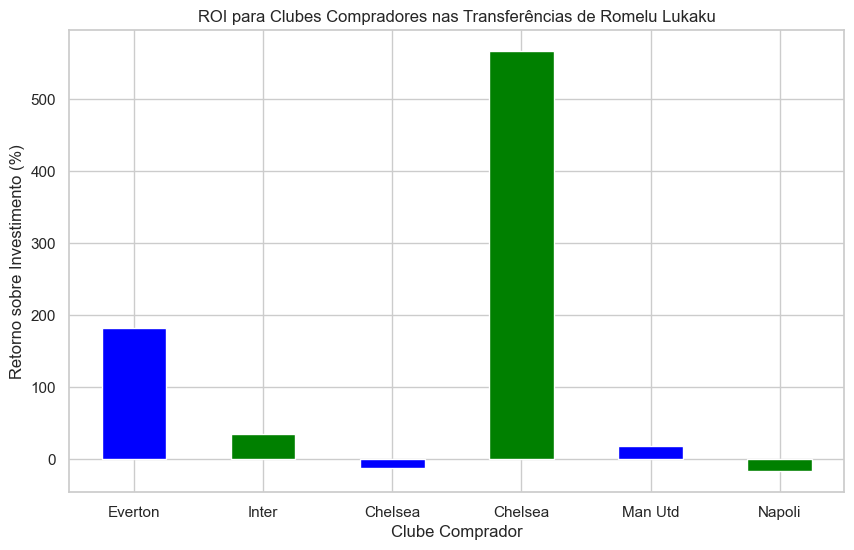

In [84]:
# --- CÉLULA DE CONSULTAS - EIXO 1 (MONGODB) ---

client = MongoClient(MONGO_URI)
db = client.football
players_collection = db.players

display(Markdown("---"))

### 1.1 - Correlação: Idade, Desempenho e Valorização
display(Markdown("Analisando a correlação entre a idade de um jogador, sua média de gols e seu valor de mercado."))

# Query MongoDB
pipeline_valor = [
    { "$match": { "valuations": { "$exists": True, "$ne": [] }, "avg_goals": { "$exists": True } } },
    { "$unwind": "$valuations" },
    { "$addFields": { "age_at_valuation": { "$divide": [{ "$subtract": ["$valuations.date", "$date_of_birth"] }, 31536000000] } } }, # Milissegundos em um ano
    { "$project": { "_id": 0, "name": 1, "age": { "$floor": "$age_at_valuation" }, "market_value_eur": "$valuations.market_value_in_eur", "avg_goals": "$avg_goals" } },
    { "$sample": { "size": 5000 } }
]
cursor_valor = players_collection.aggregate(pipeline_valor)
df_valor = pd.DataFrame(list(cursor_valor))

# Visualização
if not df_valor.empty:
    plt.figure(figsize=(14, 9))
    sns.scatterplot(data=df_valor, x='age', y='market_value_eur', hue='avg_goals', size='avg_goals', palette='viridis', sizes=(20, 200), alpha=0.7)
    plt.title('Valor de Mercado vs. Idade (Cor/Tamanho por Média de Gols)', fontsize=16)
    plt.xlabel('Idade do Jogador (anos)'); plt.ylabel('Valor de Mercado (EUR)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()

display(Markdown("---"))

### 1.2 - Clubes que mais valorizam atletas
display(Markdown("Identificando os clubes associados aos maiores saltos de valorização de jogadores."))

# Query MongoDB
pipeline_growth = [
    { "$match": { "valuations.1": { "$exists": True } } },
    { "$project": { "name": 1, "current_club_name": 1, "first_value": { "$arrayElemAt": ["$valuations", 0] }, "last_value": { "$arrayElemAt": ["$valuations", -1] } } },
    { "$addFields": { "valor_inicial": "$first_value.market_value_in_eur", "valor_final": "$last_value.market_value_in_eur", "tempo_em_dias": { "$divide": [{ "$subtract": ["$last_value.date", "$first_value.date"] }, 86400000] } } },
    { "$match": { "tempo_em_dias": { "$gt": 365, "$lt": 1095 }, "valor_inicial": { "$gt": 100000 } } },
    { "$project": { "name": 1, "current_club_name": 1, "crescimento_pct": { "$cond": { "if": { "$gt": ["$valor_inicial", 0] }, "then": { "$multiply": [{ "$divide": [{ "$subtract": ["$valor_final", "$valor_inicial"] }, "$valor_inicial"] }, 100] }, "else": 0 } } } },
    { "$sort": { "crescimento_pct": -1 } },
    { "$limit": 15 }
]
cursor_growth = players_collection.aggregate(pipeline_growth)
df_growth = pd.DataFrame(list(cursor_growth))

# Visualização
if not df_growth.empty:
    df_club_growth = df_growth.groupby('current_club_name')['crescimento_pct'].mean().sort_values(ascending=False).head(10)
    display(Markdown("#### Top 10 Clubes por Média de Crescimento Percentual de Valor"))
    df_club_growth.plot(kind='barh', color='teal')
    plt.xlabel('Média de Crescimento de Valor (%)'); plt.ylabel('Clube')
    plt.title('Clubes com Maior Média de Valorização de Jogadores'); plt.show()

display(Markdown("---"))

### 1.3 - Análise de Caso: ROI das Transferências de um jogador (MongoDB)
player_name = "Romelu Lukaku"
display(Markdown("Calculando o Retorno sobre o Investimento para o clube comprador em cada transferência de " + player_name + "."))

# Query MongoDB
pipeline_roi_player = [
    # 1. Encontrar o jogador
    { "$match": { "name": player_name } },
    
    # 2. Desdobrar o array de transferências para analisar uma por uma
    { "$unwind": "$transfers" },
    
    # 3. Filtrar apenas transferências pagas
    { "$match": { "transfers.transfer_fee": { "$gt": 0 } } },
    
    # 4. Calcular o pico de valorização APÓS cada transferência
    { "$addFields": {
        "pico_valor_pos_transferencia": {
            "$max": {
                "$map": {
                    "input": {
                        # Filtra o array de valorações para pegar apenas as datas posteriores à transferência
                        "$filter": {
                            "input": "$valuations",
                            "as": "v",
                            "cond": { "$gt": [ "$$v.date", "$transfers.transfer_date" ] }
                        }
                    },
                    "as": "valuation_filtrada",
                    "in": "$$valuation_filtrada.market_value_in_eur"
                }
            }
        }
    }},
    
    # 5. Calcular o ROI e projetar os resultados finais
    { "$project": {
        "_id": 0,
        "clube_comprador": "$transfers.to_club_name",
        "data_transferencia": "$transfers.transfer_date",
        "taxa_paga_eur": "$transfers.transfer_fee",
        "pico_valor_eur": "$pico_valor_pos_transferencia",
        "roi_percentual": {
            "$multiply": [
                { "$divide": [
                    { "$subtract": ["$pico_valor_pos_transferencia", "$transfers.transfer_fee"] },
                    "$transfers.transfer_fee"
                ]},
                100
            ]
        }
    }}
]

cursor_roi = players_collection.aggregate(pipeline_roi_player)
df_roi_player = pd.DataFrame(list(cursor_roi))

# Visualização
if not df_roi_player.empty:
    display(Markdown("#### Análise de ROI para as Transferências de " + player_name))
    display(df_roi_player)
    
    df_roi_player.plot(kind='bar', x='clube_comprador', y='roi_percentual',
                       figsize=(10, 6), color=['blue', 'green'], legend=False)
    
    plt.title('ROI para Clubes Compradores nas Transferências de ' + player_name)
    plt.ylabel('Retorno sobre Investimento (%)')
    plt.xlabel('Clube Comprador')
    plt.xticks(rotation=0)
    plt.show()

---
## Eixo 2: Análise de Impacto Tático 
Nesta seção, investigamos o Eixo 2: Impacto das Escalações e Substituições no Desempenho do Time. Para estas análises, focamos na coleção games do MongoDB, que foi projetada para conter um registro completo de cada partida, incluindo suas escalações e eventos.

O modelo de documentos do MongoDB é particularmente eficaz aqui, pois nos permite analisar os eventos e jogadores dentro do contexto de um único jogo sem a necessidade de JOINs. Utilizaremos o Aggregation Pipeline para extrair insights sobre:

- Eficácia das Formações Táticas: Avaliamos o desempenho de diferentes formações (home_club_formation) em termos de média de gols marcados e probabilidade de vitória.

- Impacto das Substituições: Analisamos em que momento do jogo (dividido em "janelas de tempo") as substituições mais ocorrem e qual o seu impacto imediato em gols.

- Contribuição Ofensiva (Titulares vs. Reservas): Comparamos diretamente a produção de gols e assistências de jogadores que iniciaram a partida (starting_lineup) contra aqueles que entraram como substitutos (substitutes).

In [ ]:
games_collection = db.games

# Consulta 1: Eficácia das Formações Táticas
display(Markdown("---"))
display(Markdown("### Consulta 1: Eficácia das Formações Táticas"))
display(Markdown("Analisando a média de gols marcados e a taxa de vitória para as formações táticas mais comuns dos times da casa."))

pipeline_formations = [
    # 1. Filtrar jogos onde a formação é conhecida
    { "$match": { "home_club_formation": { "$exists": True, "$ne": "Unknown" } } },
    
    # 2. Agrupar por formação
    { "$group": {
        "_id": "$home_club_formation",
        "total_jogos": { "$sum": 1 },
        "total_vitorias": { "$sum": { "$cond": [{ "$eq": ["$home_club_goals", "$away_club_goals"] }, 0, { "$cond": [{ "$gt": ["$home_club_goals", "$away_club_goals"] }, 1, 0] }] } }, # Soma 1 se for vitória
        "media_gols_marcados": { "$avg": "$home_club_goals" },
        "media_gols_sofridos": { "$avg": "$away_club_goals" }
    }},
    
    # 3. Calcular a taxa de vitória
    { "$addFields": {
        "taxa_de_vitoria_pct": {
            "$multiply": [{ "$divide": ["$total_vitorias", "$total_jogos"] }, 100]
        }
    }},
    
    # 4. Ordenar pelas formações mais usadas e com maior taxa de vitória
    { "$sort": { "total_jogos": -1 } },
    { "$limit": 10 }
]

cursor_formations = games_collection.aggregate(pipeline_formations)
df_formations = pd.DataFrame(list(cursor_formations))
df_formations.rename(columns={'_id': 'formacao'}, inplace=True)

if not df_formations.empty:
    display(Markdown("#### Top 10 Formações Mais Utilizadas e seu Desempenho"))
    display(df_formations.round(2))
    
    # Visualização
    fig, ax1 = plt.subplots(figsize=(14, 7))
    sns.barplot(data=df_formations, x='formacao', y='total_jogos', ax=ax1, color='skyblue', label='Total de Jogos')
    ax1.set_ylabel('Total de Jogos', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    ax2 = ax1.twinx()
    sns.lineplot(data=df_formations, x='formacao', y='taxa_de_vitoria_pct', ax=ax2, color='red', marker='o', label='Taxa de Vitória (%)')
    ax2.set_ylabel('Taxa de Vitória (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title('Análise de Desempenho por Formação Tática', fontsize=16)
    plt.show()

# Consulta 2: Análise de Impacto das Substituições
display(Markdown("---"))
display(Markdown("### Consulta 2 - Análise de Impacto das Substituições"))
display(Markdown("Investigando a distribuição de substituições ao longo do tempo de jogo e a ocorrência de gols logo após."))

pipeline_subs = [
    # 1. Desdobrar os eventos de cada jogo
    { "$unwind": "$events" },
    
    # 2. Manter apenas eventos de 'Substituição' e 'Gol'
    { "$match": { "events.event_type": { "$in": ["Substitutions", "Goals"] } } },
    
    # 3. Classificar o minuto do evento em janelas de tempo
    { "$addFields": {
        "janela_tempo": {
            "$switch": {
                "branches": [
                    { "case": { "$lte": ["$events.minute", 45] }, "then": "1º Tempo" },
                    { "case": { "$lte": ["$events.minute", 60] }, "then": "46-60 min" },
                    { "case": { "$lte": ["$events.minute", 75] }, "then": "61-75 min" },
                    { "case": { "$lte": ["$events.minute", 90] }, "then": "76-90 min" }
                ],
                "default": "Acréscimos"
            }
        }
    }},
    
    # 4. Agrupar por janela de tempo e contar substituições e gols
    { "$group": {
        "_id": "$janela_tempo",
        "total_substituicoes": { "$sum": { "$cond": [{ "$eq": ["$events.event_type", "Substitutions"] }, 1, 0] } },
        "total_gols": { "$sum": { "$cond": [{ "$eq": ["$events.event_type", "Goals"] }, 1, 0] } }
    }},
    
    # 5. Ordenar as janelas de tempo
    { "$sort": { "_id": 1 } }
]

cursor_subs = games_collection.aggregate(pipeline_subs)
df_subs_impact = pd.DataFrame(list(cursor_subs))
df_subs_impact.rename(columns={'_id': 'janela_tempo'}, inplace=True)

if not df_subs_impact.empty:
    display(Markdown("#### Contagem de Substituições e Gols por Janela de Tempo"))
    display(df_subs_impact)
    
    df_subs_impact.set_index('janela_tempo').plot(kind='bar', secondary_y='total_gols', figsize=(12, 7))
    plt.title('Distribuição de Substituições e Gols ao Longo da Partida')
    plt.xticks(rotation=0)
    plt.show()

# Consulta 3: Contribuição Ofensiva: Titulares vs. Reservas
display(Markdown("---"))
display(Markdown("### Consulta 3 - Contribuição Ofensiva: Titulares vs. Reservas"))
display(Markdown("Comparando a produção de gols e assistências entre jogadores que começaram jogando e os que entraram no decorrer da partida."))

pipeline_starters_vs_subs = [
    # 1. Desdobrar os eventos para encontrar os gols e assistências
    { "$unwind": "$events" },
    { "$match": { "events.event_type": "Goals" } },
    
    # 2. Desdobrar a escalação para saber quem era titular/reserva
    { "$unwind": "$lineup" },
    
    # 3. Juntar o autor do gol com seu status na escalação
    { "$redact": {
        "$cond": {
           "if": { "$eq": [ "$events.player_id", "$lineup.player_id" ] },
           "then": "$$KEEP",
           "else": "$$PRUNE"
        }
    }},
    
    # 4. Agrupar por tipo (titular/reserva) e somar os gols
    { "$group": {
        "_id": "$lineup.lineup_type",
        "total_gols": { "$sum": 1 }
    }},
    
    # 5. Renomear o campo _id
    { "$project": {
        "_id": 0,
        "tipo_jogador": "$_id",
        "total_gols": 1
    }}
]

cursor_svs = games_collection.aggregate(pipeline_starters_vs_subs)
df_svs = pd.DataFrame(list(cursor_svs))

if not df_svs.empty:
    display(Markdown("#### Total de Gols Marcados por Titulares vs. Reservas"))
    display(df_svs)

    sns.barplot(data=df_svs, x='tipo_jogador', y='total_gols', palette=['#3498db', '#f1c40f'])
    plt.title('Gols Totais: Titulares (starting_lineup) vs. Reservas (substitutes)')
    plt.xlabel('Status do Jogador na Partida')
    plt.ylabel('Número Total de Gols')
    plt.show()

---
## Eixo 3: Análise de Carreira e Redes de Transferência

Nesta seção, a análise se aprofunda nas conexões e na dinâmica do mercado de transferências, focando nas perguntas do **Eixo 3: Análise da Carreira e Padrões de Trajetória de Jogadores**. Para isso, os dados são consultados diretamente do **Neo4j**, o banco de dados de grafos populado na etapa de carga.

A escolha do Neo4j para esta análise é estratégica. Seu modelo de dados nativo de grafos é otimizado para percorrer e analisar relacionamentos complexos. Questões sobre caminhos, conexões e redes, que seriam extremamente custosas e complexas em bancos de dados relacionais ou de documentos (exigindo múltiplos `JOINs` ou agregações complexas), são respondidas de forma natural e eficiente no Neo4j.

Utilizaremos a linguagem de consulta **Cypher** para realizar as seguintes análises:

1.  **Mapeamento da Trajetória de Carreira de um Jogador:** Investigaremos a carreira de um atleta individualmente. A consulta Cypher irá localizar o nó do jogador e, a partir dele, percorrer seus relacionamentos de entrada (`:TRANSFERRED_FROM`) e saída (`:TRANSFERRED_TO`) em ordem cronológica para reconstruir visualmente sua jornada entre clubes.

2.  **Identificação de Padrões de Transferência Comuns:** Buscaremos entender os principais fluxos de talentos no futebol mundial. A consulta irá identificar padrões de caminho `(Clube_A) <-[:TRANSFERRED_FROM]- (Jogador) -[:TRANSFERRED_TO]-> (Clube_B)`, agregando esses dados por país para revelar as "rodovias" de transferência mais utilizadas entre as nações.

3.  **Descoberta de "Clusters" de Relacionamento entre Clubes:** Identificaremos quais clubes possuem um forte relacionamento comercial. A consulta irá procurar pares de clubes que negociaram jogadores entre si, quantificando a força desse laço pelo número de transações. Isso nos permite visualizar "clusters" e parcerias no mercado da bola.

As saídas dessas consultas serão convertidas para DataFrames `Pandas` para a criação de gráficos de barras com `Matplotlib`/`Seaborn` ou processadas pela biblioteca `Pyvis` para gerar visualizações de grafos de rede interativas.


Grafo da trajetória salvo como 'career_journey_álvaro_morata.html'
career_journey_álvaro_morata.html


/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_20197/2126949652.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_routes, x='number_of_players', y='route', palette='viridis')
/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_20197/2126949652.py:125: UserWarning: Glyph 10140 (\N{HEAVY ROUND-TIPPED RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m7/0vkmn80144lcqcp11ggbb3v00000gn/T/ipykernel_20197/2126949652.py:126: UserWarning: Glyph 10140 (\N{HEAVY ROUND-TIPPED RIGHTWARDS ARROW}) missing from font(s) Arial.
  plt.savefig("top_transfer_routes.png")
/Users/pedronogueira/.pyenv/versions/3.11.13/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10140 (\N{HEAVY ROUND-TIPPED RIGHTWARDS ARROW}) missing from font(s) Arial.
  fig.canvas.print_figure(byt

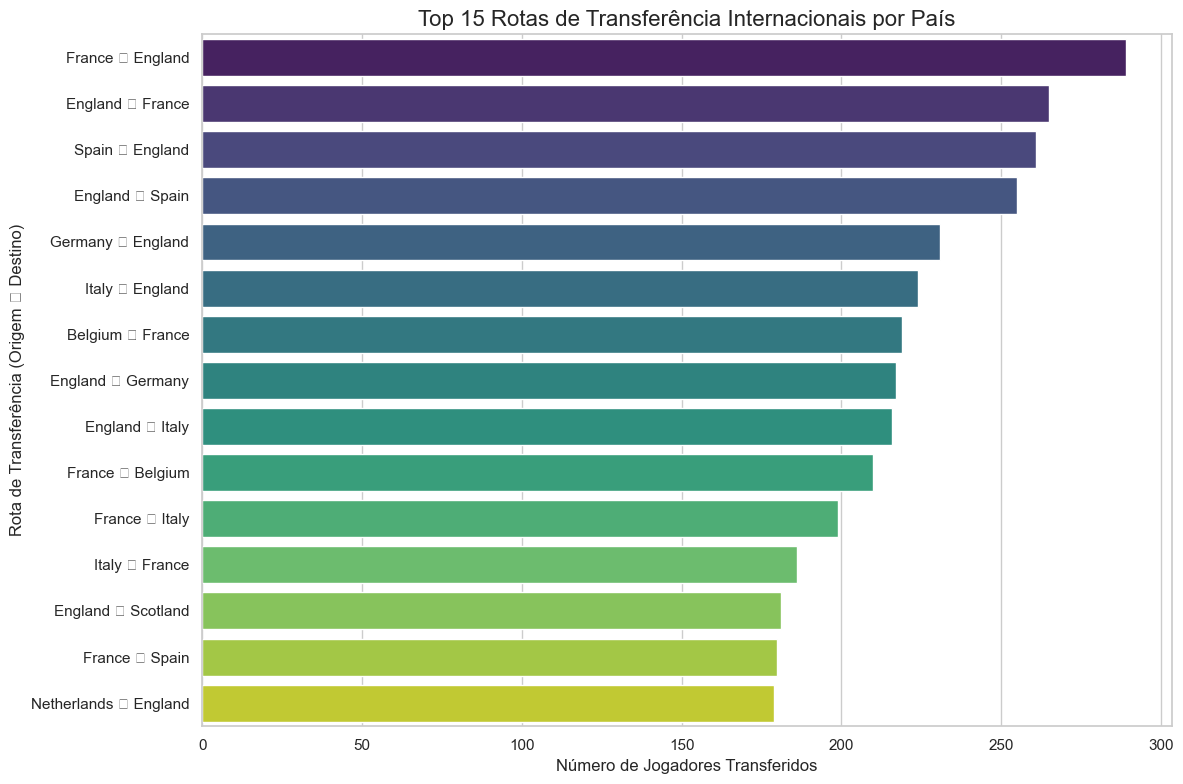

Gráfico de rotas salvo como 'top_transfer_routes.png'


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function. ('id' has been replaced by 'elementId or consider using an application-generated id')} {position: line: 3, column: 11, offset: 92} for query: '\n    MATCH (c1:Club)<-[:TRANSFERRED_FROM]-(p:Player)-[:TRANSFERRED_TO]->(c2:Club)\n    WHERE id(c1) < id(c2)\n    RETURN c1.name AS club1, c2.name AS club2, count(p) AS total_trades\n    ORDER BY total_trades DESC\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function. ('id' has been replaced by 'elementId or consider using an application-genera

Grafo de clusters de clubes salvo como 'club_clusters_threshold_30.html'
club_clusters_threshold_30.html


In [17]:
# Consulta 1: Mapeamento da Trajetória da Carreira de um Jogador
def plot_player_career_journey(player_name: str):
    """
    Busca a trajetória de transferências de um jogador e a plota como um caminho sequencial,
    iniciando pelo próprio jogador e com um layout estático e otimizado.
    """
    URI = os.getenv("NEO4J_URI")
    AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

    query = """
    MATCH (p:Player {name: $player_name})
    MATCH (origin_club:Club)<-[r_from:TRANSFERRED_FROM]-(p)
    MATCH (p)-[r_to:TRANSFERRED_TO]->(destination_club:Club)
    WHERE r_from.date = r_to.date
    RETURN 
        origin_club.name AS origin, 
        destination_club.name AS destination, 
        r_to.date AS date,
        r_to.transfer_fee AS fee
    ORDER BY date ASC
    """

    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        records, _, _ = driver.execute_query(query, player_name=player_name, database_="neo4j")

    if not records:
        print(f"Nenhuma trajetória de transferência encontrada para o jogador: {player_name}")
        return

    net = Network(height="700px", width="100%", bgcolor="#222222", font_color="white", notebook=True, directed=True, cdn_resources='in_line')
    
    net.add_node(player_name, label=player_name, size=25, color="#FFD700", shape='star', title=f"Carreira de {player_name}")

    # Adiciona todos os nós de clube de uma vez para evitar duplicatas
    all_clubs = set()
    for record in records:
        all_clubs.add(record["origin"])
        all_clubs.add(record["destination"])
    
    for club in all_clubs:
        net.add_node(club, label=club, size=15, color="#0096C7")

    # Cria a aresta inicial, do jogador para o primeiro clube da sua primeira transferência
    first_transfer = records[0]
    first_club = first_transfer["origin"]
    first_date = first_transfer["date"].strftime('%Y-%m')
    net.add_edge(player_name, first_club, label=f"Início da Carreira\nRegistrada ({first_date})", title=f"Primeira transferência em {first_date}", width=2.5, color="#FFFFFF")
    
    # Adiciona as arestas sequenciais entre os clubes
    for i, record in enumerate(records):
        origin = record["origin"]
        destination = record["destination"]
        date_str = record["date"].strftime('%Y-%m')
        fee_value = record["fee"]
        
        fee_str = f"€{fee_value/1e6:.1f}M" if fee_value > 0 else "Grátis"
        edge_label = f"{i+1}. {date_str}\n{fee_str}"
        
        net.add_edge(
            source=origin,
            to=destination,
            label=edge_label,
            title=f"Transferência em {date_str} por {fee_str}",
            width=2
        )

    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -100,
          "centralGravity": 0.01,
          "springLength": 300,
          "springConstant": 0,
          "avoidOverlap": 0.5
        },
        "maxVelocity": 0,
        "minVelocity": 0,
        "solver": "barnesHut",
        "timestep": 0.5
      }
    }
    """)
    
    file_name = f"career_journey_{player_name.replace(' ', '_').lower()}.html"
    print(f"Grafo da trajetória salvo como '{file_name}'")
    return net.show(file_name)

plot_player_career_journey("Álvaro Morata")

# Consulta 2: Identificação de Padrões de Transferência Comuns
def analyze_transfer_routes_by_country(limit=15):
    URI = os.getenv("NEO4J_URI")
    AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
    
    query = """
    MATCH (origin_club:Club)<-[:TRANSFERRED_FROM]-(p:Player)-[:TRANSFERRED_TO]->(destination_club:Club)
    WHERE origin_club.country <> destination_club.country
      AND origin_club.country <> 'Unknown'
      AND destination_club.country <> 'Unknown'
    RETURN
        origin_club.country AS origin_country,
        destination_club.country AS destination_country,
        count(DISTINCT p) AS number_of_players
    ORDER BY number_of_players DESC
    LIMIT $limit
    """
    
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        records, _, _ = driver.execute_query(query, limit=limit)

    if not records:
        print("Não foi possível gerar as rotas de transferência.")
        return
        
    df_routes = pd.DataFrame([r.data() for r in records])
    df_routes['route'] = df_routes['origin_country'] + ' ➜ ' + df_routes['destination_country']

    # Visualização
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_routes, x='number_of_players', y='route', palette='viridis')
    plt.title(f'Top {limit} Rotas de Transferência Internacionais por País', fontsize=16)
    plt.xlabel('Número de Jogadores Transferidos', fontsize=12)
    plt.ylabel('Rota de Transferência (Origem ➜ Destino)', fontsize=12)
    plt.tight_layout()
    plt.savefig("top_transfer_routes.png")
    plt.show()
    print("Gráfico de rotas salvo como 'top_transfer_routes.png'")

analyze_transfer_routes_by_country()

# Consulta 3: Visualização de Clusters de Clubes

def visualize_club_clusters_fixed(trade_threshold=5):
    URI = os.getenv("NEO4J_URI")
    AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
    
    query = """
    MATCH (c1:Club)<-[:TRANSFERRED_FROM]-(p:Player)-[:TRANSFERRED_TO]->(c2:Club)
    WHERE id(c1) < id(c2)
    RETURN c1.name AS club1, c2.name AS club2, count(p) AS total_trades
    ORDER BY total_trades DESC
    """
    
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        records, _, _ = driver.execute_query(query, database_="neo4j")
    
    df_trades = pd.DataFrame([r.data() for r in records])
    df_filtered = df_trades[df_trades['total_trades'] >= trade_threshold]

    if df_filtered.empty:
        print(f"Nenhum cluster de clubes encontrado com um mínimo de {trade_threshold} negociações.")
        return

    net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", notebook=True, cdn_resources='in_line')
    
    for index, row in df_filtered.iterrows():
        club1, club2, trades = row['club1'], row['club2'], row['total_trades']
        net.add_node(club1, label=club1, size=trades*2, title=f"Negociações: {trades}")
        net.add_node(club2, label=club2, size=trades*2, title=f"Negociações: {trades}")
        net.add_edge(club1, club2, title=f"{trades} negociações", value=trades)

    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -200000,
          "springConstant": 0.04,
          "springLength": 250
        },
        "minVelocity": 0.75
      }
    }
    """)

    file_name = f"club_clusters_threshold_{trade_threshold}.html"
    print(f"Grafo de clusters de clubes salvo como '{file_name}'")
    return net.show(file_name)

# O threshold define o número mínimo de negociações para mostrar uma conexão
visualize_club_clusters_fixed(trade_threshold=30)